<h2>Project Workbook<h2>

Author: Irene Berezin, Kaiyan Zhang, Niko Bauer, Jerrold Huang

In [169]:
# Installing required packages
install.packages("sandwich")
install.packages("coefplot")
install.packages("lmtest")
install.packages("kableExtra")


Warning message:
"package 'sandwich' is in use and will not be installed"
Warning message:
"package 'coefplot' is in use and will not be installed"
Warning message:
"package 'lmtest' is in use and will not be installed"
Warning message:
"package 'kableExtra' is in use and will not be installed"


In [170]:
# Loading packages
library(geojsonio)
library(tidyverse)
library(ggplot2)
library(tidyr)
library(dplyr)
library("knitr")
library(broom)
library(stargazer)
library(units)
library(sf)
library(car)
library(sandwich)
library(coefplot)
library(lmtest)
library(VancouvR)
library("kableExtra")

## Data Pre-processing 

This section contains our pre-processing done to all our datasets.

In [171]:
# reading in cancensus variables


library(cancensus)
options(cancensus.api_key='CensusMapper_f228791d9506a7a747ece66db73b95be')
options(cancensus.cache_path = "/cache")

census_data <- get_census(dataset='CA16', regions=list(CSD="5915022"), vectors=c("v_CA16_379", "v_CA16_401","v_CA16_404","v_CA16_406","v_CA16_1","v_CA16_2396","v_CA16_2510", "v_CA16_5078", "v_CA16_3411", "v_CA16_2397"), labels="detailed", geo_format="sf", level='DA')

census_data_clean <- census_data|>
    rename(
        name = 'GeoUID',
        households = Households, 
        dwellings = Dwellings, 
        population = `v_CA16_401: Population, 2016` ,
        population_density = 'v_CA16_406: Population density per square kilometre', 
        region = `Region Name` , 
        area_sq_km = `Area (sq km)`, 
        age =  `v_CA16_379: Average age` , 
        income = `v_CA16_2397: Median total income of households in 2015 ($)`,
        education = `v_CA16_5078: University certificate, diploma or degree at bachelor level or above`,
        immigrant = 'v_CA16_3411: Immigrants'    
    )|>
    filter(region == "Vancouver")|>
    mutate(immigrant_prop = immigrant/population) |>
    mutate(education_prop = education / population)|>
    mutate(income = income / 100000)|>
    select(name, households, dwellings, population,population_density, region, area_sq_km, age, income, immigrant_prop, education_prop)|>
    glimpse()

census_data_st <- st_sf(census_data_clean, geometry = census_data_clean$geometry, crs = 4326)
census_data_centroid <- st_centroid(census_data_clean)

Reading vectors data from local cache.

Reading geo data from local cache.



Rows: 993
Columns: 12
$ name               <chr> "59150307", "59150308", "59150309", "59150310", "59…
$ households         <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174, 2…
$ dwellings          <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189, 3…
$ population         <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506, …
$ population_density <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 629…
$ region             <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vancouv…
$ area_sq_km         <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0870…
$ age                <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.6, 42.…
$ income             <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.7436…
$ immigrant_prop     <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.40413…
$ education_prop     <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.25375…
$ geometry           <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MULTIP…


Warning message:
"st_centroid assumes attributes are constant over geometries"


In [172]:
# reading in crime data

url = "https://raw.githubusercontent.com/Irene-Berezin/econ326/refs/heads/main/crimedata_csv_AllNeighbourhoods_AllYears/crimedata_csv_AllNeighbourhoods_AllYears.csv"
intentional_crime_data <- read_csv(url)|>
    rename(type = TYPE, year = YEAR, neighbourhood = NEIGHBOURHOOD, x = X, y = Y)|>
    select(type, year, neighbourhood, x, y)|>
    filter(!type %in% c("Vehicle Collision or Pedestrian Struck (with Fatality)",
    "Vehicle Collision or Pedestrian Struck (with Injury)",
    "Mischief"))|>
    filter(year == 2016)|>
    filter(x!=0, y!=0)|>
    group_by(type)|>
    arrange(year)

glimpse(intentional_crime_data)


intentional_crime_sf <- intentional_crime_data|>
    st_as_sf(coords = c("x", "y"), crs = 32610)|>
    st_transform(crs = 4326)|>
    glimpse()

intentional_crime_count <- intentional_crime_data|>
    mutate(neighbourhood = if_else(neighbourhood == "Central Business District", "Downtown", neighbourhood))|>
    group_by(type)|>
    summarize(crime_count = n())|>
    glimpse()

colnames(intentional_crime_count)[colnames(intentional_crime_count) == "neighbourhood"] <- "name"

crime_in_census_divisions <- st_join(intentional_crime_sf, census_data_st, left = FALSE)

crime_counts <- crime_in_census_divisions %>%
  group_by(name) %>% 
  summarise(crime_count = n())|>
  st_drop_geometry()|>
  glimpse()

Rows: 895823 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 34,582
Columns: 5
Groups: type [6]
$ type          <chr> "Other Theft", "Other Theft", "Other Theft", "Other Thef…
$ year          <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20…
$ neighbourhood <chr> "West End", "West End", "West End", "West End", "West En…
$ x             <dbl> 491004.8, 491004.8, 491007.8, 491007.8, 491007.8, 491007…
$ y             <dbl> 5459177, 5459177, 5459174, 5459174, 5459174, 5459174, 54…
Rows: 34,582
Columns: 4
Groups: type [6]
$ type          <chr> "Other Theft", "Other Theft", "Other Theft", "Other Thef…
$ year          <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20…
$ neighbourhood <chr> "West End", "West End", "West End", "West End", "West En…
$ geometry      <POINT [°]> POINT (-123.1237 49.28528), POINT (-123.1237 49.28…
Rows: 6
Columns: 2
$ type        <chr> "Break and Enter Commercial", "Break and Enter Residential…
$ crime_count <int> 2683, 2989, 11981, 12814, 2637, 1478
Rows: 993
Columns: 2
$ name        <chr> "

In [173]:
# reading in light data
light_data <- get_cov_data(dataset_id = 'street-lighting-poles')|>
    st_sf()|>
    glimpse()

Reading data from temporary cache



Rows: 57,737
Columns: 6
$ block_number   <chr> "37", "83", "18", "45", "84", "45", "20", "81", "26", "…
$ node_number    <dbl> 4, 2, 2, 6, 1, 4, 1, 1, 2, 5, 3, 1, 1, 6, 3, 4, 7, 2, 2…
$ geom           <chr> "{\"coordinates\": [-123.18777580128182, 49.25982319071…
$ geo_local_area <chr> "West Point Grey", "Hastings-Sunrise", "West End", "Wes…
$ geo_point_2d   <chr> "49.25982319071583, -123.18777580128182", "49.280140856…
$ geometry       <POINT [°]> POINT (-123.1878 49.25982), POINT (-123.0334 49.2…


In [174]:
# reading in tax data and local area boundaries

search_cov_datasets("property-tax") %>%
  select(dataset_id,title)

tax_data <- get_cov_data(dataset_id = "property-tax-report-2016-2019",
                         where="tax_assessment_year='2016'",
                         select = "current_land_value, land_coordinate as tax_coord")|>
    as.tibble()
glimpse(tax_data) # read in the data of land value, and changed it coordname to tax coord, so it matched the property polygon data


local_area_boundary <- get_cov_data(dataset_id ="local-area-boundary")|>
    glimpse()



property_polygons <- get_cov_data(dataset_id="property-parcel-polygons")|>
    glimpse()


census_geom <- st_geometry(census_data)
census_centroids <- st_centroid(census_geom)

dataset_id,title
<chr>,<chr>
property-tax-report-2016-2019,Property tax report 2016-2019
property-tax-report-2006-2010,Property tax report 2006-2010
property-tax-report-2011-2015,Property tax report 2011-2015
property-tax-report,Property tax report


Reading data from temporary cache

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `current_land_value =
  .Primitive("as.integer")(current_land_value)`.
Caused by warning:
! NAs introduced by coercion to integer range"


Rows: 199,924
Columns: 2
$ current_land_value <int> 126000, 1100000, 1028000, 825000, 922000, 878000, 1…
$ tax_coord          <chr> "58825549", "60125529", "61223603", "63025324", "59…


Reading data from temporary cache



Rows: 22
Columns: 4
$ name         <chr> "Downtown", "Hastings-Sunrise", "Kerrisdale", "Marpole", …
$ geom         <chr> "{\"coordinates\": [[[-123.11226654052733, 49.29016494657…
$ geo_point_2d <chr> "49.28074707013743, -123.11656700827415", "49.27793405209…
$ geometry     <POLYGON [°]> POLYGON ((-123.1123 49.2901..., POLYGON ((-123.05…


Reading data from temporary cache



Rows: 99,928
Columns: 7
$ civic_number <chr> "5229", "5205", "5187", "5139", "5250", "5318", "5305", "…
$ streetname   <chr> "ST. CATHERINES ST", "ST. CATHERINES ST", "ST. CATHERINES…
$ tax_coord    <chr> "21373535", "21373525", "21373521", "21373511", "21173544…
$ site_id      <chr> "003615260", "014837161", "014837188", "014837269", "0148…
$ geom         <chr> "{\"coordinates\": [[[-123.08741432194573, 49.23755135801…
$ geo_point_2d <chr> "49.23759412685341, -123.08720827261872", "49.23777480488…
$ geometry     <POLYGON [°]> POLYGON ((-123.0874 49.2375..., POLYGON ((-123.08…


In [175]:
# Merge two datasets so we have land price and their geometry information in one single dataframe
land_price <- merge(tax_data, property_polygons, by = "tax_coord")|>
    glimpse() 


land_price_sf <- st_sf(land_price, geometry = land_price$geometry, crs = 4326)

land_price_adjusted <- land_price_sf|>
    mutate(current_land_value = current_land_value/1000000)|>
    glimpse()

log_land_price <- land_price_adjusted |>
mutate(current_land_value = log(current_land_value))

Rows: 204,244
Columns: 8
$ tax_coord          <chr> "01963206", "01963229", "01963245", "01963265", "01…
$ current_land_value <int> 11366000, 10623000, 10763000, 10763000, 12864000, 1…
$ civic_number       <chr> "4888", "4898", "4874", "4850", "4811", "4818", "16…
$ streetname         <chr> "BELMONT AV", "FANNIN AV", "FANNIN AV", "FANNIN AV"…
$ site_id            <chr> "010862706", "010863915", "010863923", "010863931",…
$ geom               <chr> "{\"coordinates\": [[[-123.22221178283283, 49.27466…
$ geo_point_2d       <chr> "49.27488185499064, -123.22286857659084", "49.27431…
$ geometry           <POLYGON [°]> POLYGON ((-123.2222 49.2746..., POLYGON ((-…
Rows: 204,244
Columns: 8
$ tax_coord          <chr> "01963206", "01963229", "01963245", "01963265", "01…
$ current_land_value <dbl> 11.366, 10.623, 10.763, 10.763, 12.864, 11.195, 15.…
$ civic_number       <chr> "4888", "4898", "4874", "4850", "4811", "4818", "16…
$ streetname         <chr> "BELMONT AV", "FANNIN AV", "FANNIN AV", "FA

In [176]:
# school data

school_data <- get_cov_data(dataset_id = "schools")|>
    as.tibble()
glimpse(school_data)

school_data_st <- st_sf(school_data, geometry = school_data$geometry, crs = 4326)

Reading data from temporary cache



Rows: 194
Columns: 7
$ address         <chr> "4195 Alexandra St", "3663 Penticton St", "3455 W King…
$ school_category <chr> "Independent School", "Public School", "Public School"…
$ school_name     <chr> "Little Flower Academy", "Lord Beaconsfield Elementary…
$ geom            <chr> "{\"coordinates\": [-123.14226149913934, 49.2484313418…
$ geo_local_area  <chr> "Shaughnessy", "Renfrew-Collingwood", "Dunbar-Southlan…
$ geo_point_2d    <chr> "49.24843134181949, -123.14226149913934", "49.25213837…
$ geometry        <POINT [°]> POINT (-123.1423 49.24843), POINT (-123.0527 49.…


In [177]:
# reading in culture space data
cultural_space <- get_cov_data("cultural-spaces")|>
    as_tibble()|>
    st_sf()|>
    glimpse()

Reading data from temporary cache



Rows: 1,942
Columns: 14
$ year                <chr> "2017", "2017", "2017", "2017", "2017", "2017", "2…
$ cultural_space_name <chr> "221A Artist Run Centre", "222 E Georgia Studios",…
$ website             <chr> "www.221a.ca/?", "http://projectspace.ca/blog/", N…
$ type                <chr> "Museum/Gallery", "Studio/Rehearsal", "Community S…
$ primary_use         <chr> "Museum/Gallery", "Artist Studio", "Community Cent…
$ address             <chr> "221 E Georgia St, Vancouver, BC, V6A 1Z6", "222 E…
$ local_area          <chr> "Strathcona", "Strathcona", "West Point Grey", "Do…
$ ownership           <chr> "Privately Owned", "Privately Owned", "City of Van…
$ square_feet         <int> 9000, 7800, 2930, 4095, NA, NA, 17790, 18000, 3000…
$ number_of_seats     <int> NA, NA, NA, 30, NA, 60, 430, NA, NA, NA, NA, NA, N…
$ active_space        <chr> "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "…
$ geom                <chr> "{\"coordinates\": [-123.098796, 49.278786], \"typ…
$ geo_point_2d  

In [178]:
# Calculate the crime rate
census_data_with_crime <- census_data_st %>%
  left_join(crime_counts, by = "name") %>%
  mutate(crime_count = ifelse(is.na(crime_count), 0, crime_count))

census_crime <- census_data_with_crime %>%
  mutate(crime_rate = crime_count / population * 10000)|>
  glimpse()|>
  st_drop_geometry()|>
  select(name, crime_count, crime_rate)

Rows: 993
Columns: 14
$ name               <chr> "59150307", "59150308", "59150309", "59150310", "59…
$ households         <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174, 2…
$ dwellings          <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189, 3…
$ population         <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506, …
$ population_density <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 629…
$ region             <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vancouv…
$ area_sq_km         <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0870…
$ age                <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.6, 42.…
$ income             <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.7436…
$ immigrant_prop     <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.40413…
$ education_prop     <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.25375…
$ crime_count        <int> 28, 16, 31, 24, 14, 13, 20, 15, 23, 12, 15, 12, 8, …
$ geometry        

In [179]:
compute_accessibility_index <- function(local_areas, points_of_interest, category_name) {
  local_areas <- st_transform(local_areas, crs = 4326)
  points_of_interest <- st_transform(points_of_interest, crs = 4326)
  
  # local_areas <- left_join(local_areas, population_data, by = "name")
  
  areas_union <- st_union(local_areas)
  points_of_interest <- st_intersection(points_of_interest, areas_union)
  
  area_centroids <- st_centroid(local_areas)
  
  # Calculate average distance from each local area to points of interest
  distance_matrix <- st_distance(area_centroids, points_of_interest)
  distance_matrix_km <- set_units(distance_matrix, "km")
  avg_distance_km <- apply(distance_matrix_km, 1, mean, na.rm = TRUE)
  local_areas$avg_distance_km <- avg_distance_km
  
  # Calculate points of interest density
  local_areas$area_km2 <- st_area(local_areas) %>% set_units("km^2") %>% set_units(NULL)

  points_in_areas <- st_join(points_of_interest, local_areas, join = st_within)
  poi_counts <- points_in_areas %>%
    st_set_geometry(NULL) %>%
    group_by_at("name") %>%
    summarise(poi_count = n())
  
  local_areas <- left_join(local_areas, poi_counts, by = "name")
  local_areas$poi_count[is.na(local_areas$poi_count)] <- 0

  local_areas$poi_density <- local_areas$poi_count / local_areas$area_km2
  
  # Calculate points per 10,000 population
  local_areas$poi_per_10k_pop <- (local_areas$poi_count / local_areas$population) * 10000
  
  # Normalize the values ([0, 10] range)
  normalize <- function(x) {
    return((x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE)))
  }
  
  local_areas$avg_distance_norm <- normalize(avg_distance_km)
  local_areas$poi_density_norm <- normalize(local_areas$poi_density)
  local_areas$poi_per_10k_pop_norm <- normalize(local_areas$poi_per_10k_pop)
  
  local_areas$avg_distance_norm_inv <- 1 - local_areas$avg_distance_norm
  
  local_areas[[category_name]] <- 10*(local_areas$avg_distance_norm_inv +
                                      local_areas$poi_density_norm +
                                      local_areas$poi_per_10k_pop_norm) / 3
  
  # Normalize the values ([1, 10] range)
  local_areas[[category_name]] <- 1 + (local_areas[[category_name]] * 9 / 10)
  
  return(local_areas)
}


In [180]:
census_with_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = school_data_st,
  category_name = "school_index"
)|>
  glimpse()

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Rows: 993
Columns: 22
$ name                  <chr> "59150307", "59150308", "59150309", "59150310", …
$ households            <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174…
$ dwellings             <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189…
$ population            <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 50…
$ population_density    <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, …
$ region                <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanc…
$ area_sq_km            <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0…
$ age                   <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.6, …
$ income                <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.7…
$ immigrant_prop        <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.40…
$ education_prop        <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.25…
$ avg_distance_km       <dbl> 7.535841, 7.253416, 6.976612, 7.089322, 6.790936…
$ area_km2        

In [181]:
light_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = light_data,
  category_name = "light_index"
)|>
  pull(light_index)

census_with_index$light_index <- light_index

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


In [182]:
bus_stops <- st_read("./transit_data/Stops.shp")

local_areas <- st_read("./transit_data/local-area-boundary.geojson")

bus_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = bus_stops,
  category_name = "bus_index"
)|>
pull(bus_index)

census_with_index$bus_index <- bus_index
  

Reading layer `Stops' from data source `C:\econ326-1\transit_data\Stops.shp' using driver `ESRI Shapefile'
Simple feature collection with 8785 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -123.4231 ymin: 49.00439 xmax: -122.3029 ymax: 49.47356
Geodetic CRS:  WGS 84
Reading layer `local-area-boundary' from data source 
  `C:\econ326-1\transit_data\local-area-boundary.geojson' using driver `GeoJSON'
Simple feature collection with 22 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -123.2248 ymin: 49.19894 xmax: -123.0232 ymax: 49.29581
Geodetic CRS:  WGS 84


Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


In [183]:
cultural_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = cultural_space,
  category_name = "cultural_space_index"
)|>
pull(cultural_space_index)

census_with_index$cultural_space_index <- cultural_index

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


In [184]:
land_price_adjusted <- st_as_sf(land_price_adjusted)

properties_with_divisions <- st_join(land_price_adjusted, census_data_st, join = st_within)

mean_property_values <- properties_with_divisions|>
  group_by(name) |>
  summarize(mean_land_value = mean(current_land_value, na.rm = TRUE)) |>
  ungroup()|>
  st_drop_geometry()

log_land_price_adjusted <- st_as_sf(log_land_price)

properties_with_divisions_log <- st_join(log_land_price_adjusted, census_data_st, join = st_within)

log_mean_property_values <- properties_with_divisions_log|>
  group_by(name) |>
  summarize(mean_land_value = mean(current_land_value, na.rm = TRUE)) |>
  ungroup()|>
  st_drop_geometry()

In [185]:
# merge dataset for regressions
census_index_crime <- census_with_index |>
  left_join(mean_property_values, by = "name") |>
  left_join(census_crime, by = "name")|>
  select(name:education_prop, school_index:geometry)|> 
  mutate(across(c(immigrant_prop, education_prop, mean_land_value,income), as.double))|>
  na.omit()|>
  glimpse()

# clean dataset for graphs
census_index_crime_graphs <- census_index_crime |>
mutate(mean_land_value = log(1 + mean_land_value))

Rows: 989
Columns: 19
$ name                 <chr> "59150307", "59150308", "59150309", "59150310", "…
$ households           <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174,…
$ dwellings            <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189,…
$ population           <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506…
$ population_density   <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 6…
$ region               <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanco…
$ area_sq_km           <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.08…
$ age                  <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.6, 4…
$ income               <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.74…
$ immigrant_prop       <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.404…
$ education_prop       <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.253…
$ school_index         <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388786,…
$ light_index     

### Data visualization with map

In [186]:
# Get map
install.packages("ggmap")
library(ggmap)

key = '953a00a4-1c69-45b1-a0e4-b3492abdf92b'

register_stadiamaps(key, write = FALSE)

Warning message:
"package 'ggmap' is in use and will not be installed"


ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.

ℹ 42 tiles needed, this may take a while (try a smaller zoom?)



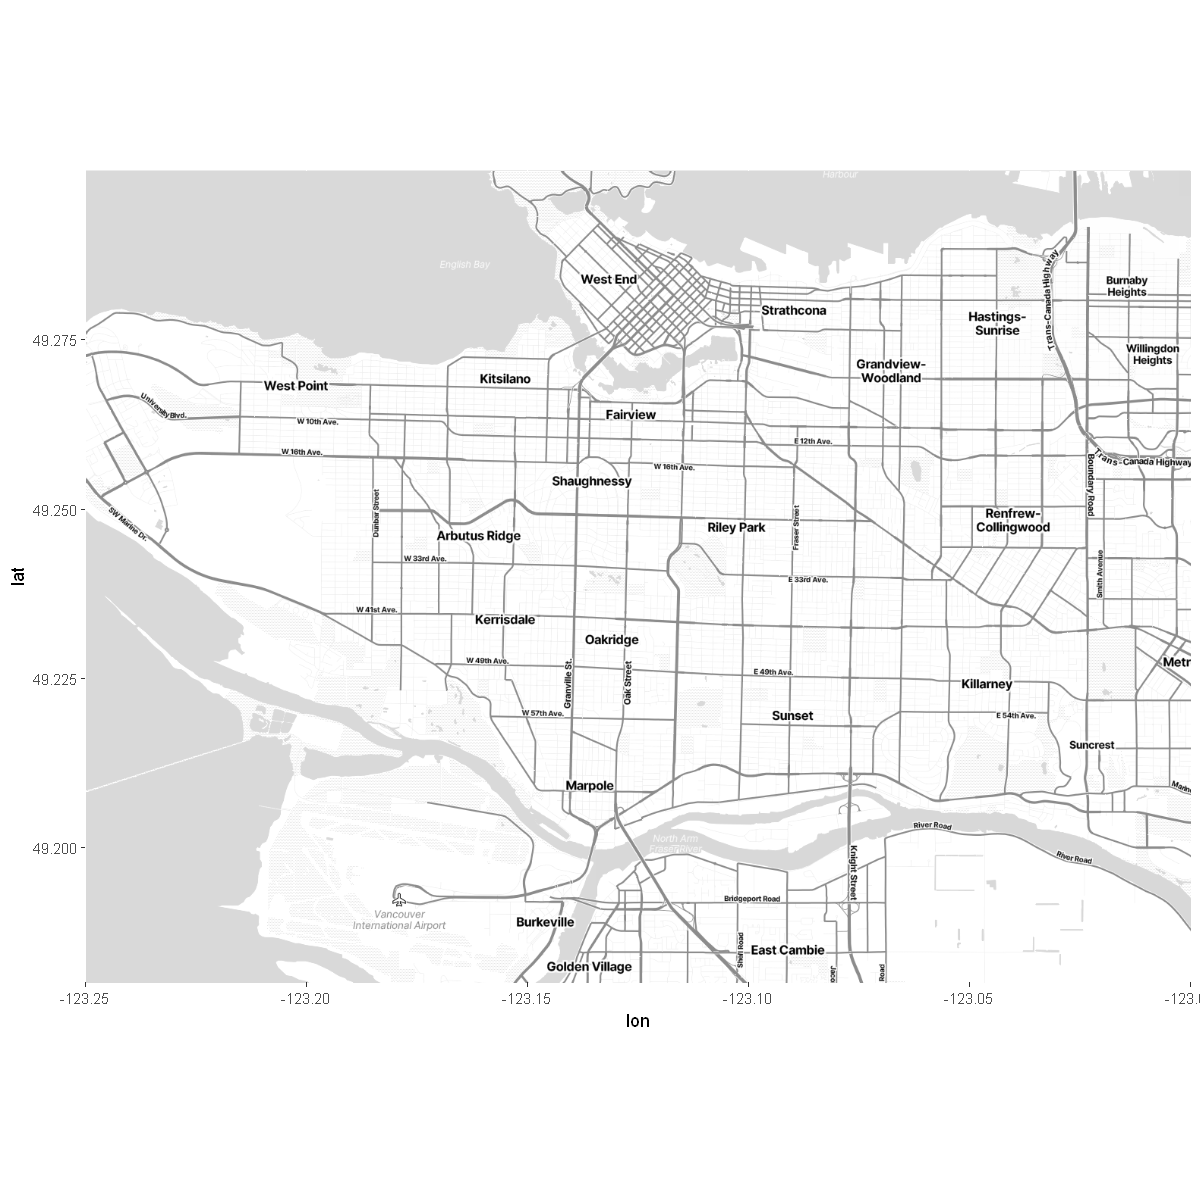

In [187]:
bbox <- c(left = -123.25, bottom = 49.18, right = -123.0, top = 49.3)

base <- get_stadiamap(bbox = bbox, zoom = 13, maptype = "stamen_toner_lite", filetype = "svg")
ggmap(base)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


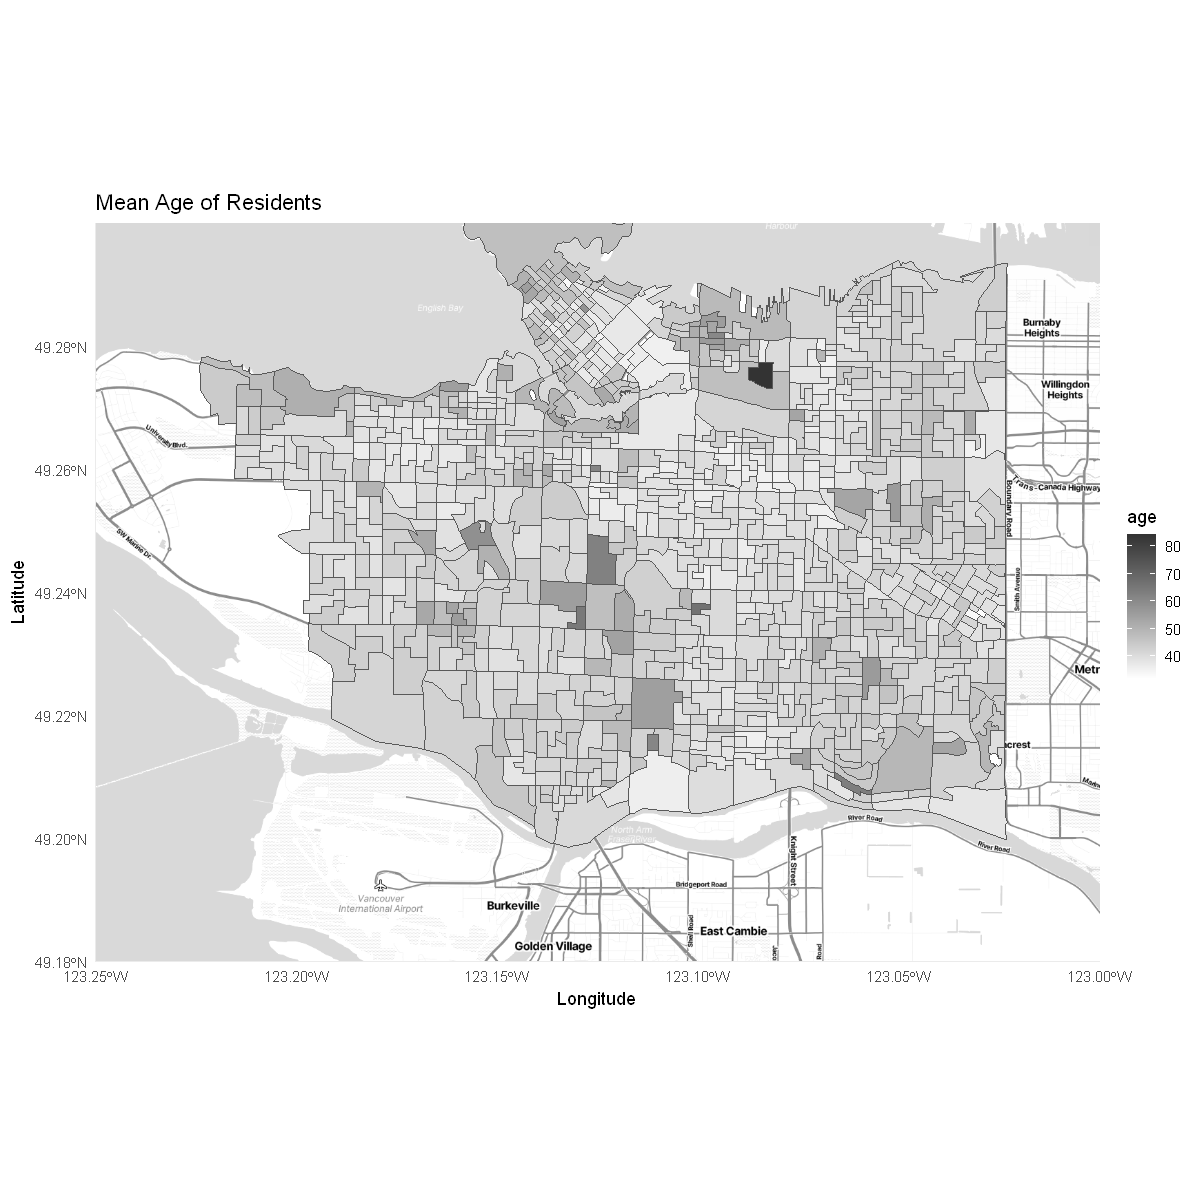

In [188]:
# Add visualization for age  data

options(repr.plot.width = 10, repr.plot.height = 10)


mean_age_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = age), inherit.aes = FALSE) +
  scale_fill_viridis_c(option = "plasma", name = "Mean Land Value") +
  coord_sf(crs = st_crs(4326)) +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  theme_minimal() +
  labs(title = "Mean Age of Residents", x = "Longitude", y = "Latitude")

mean_age_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


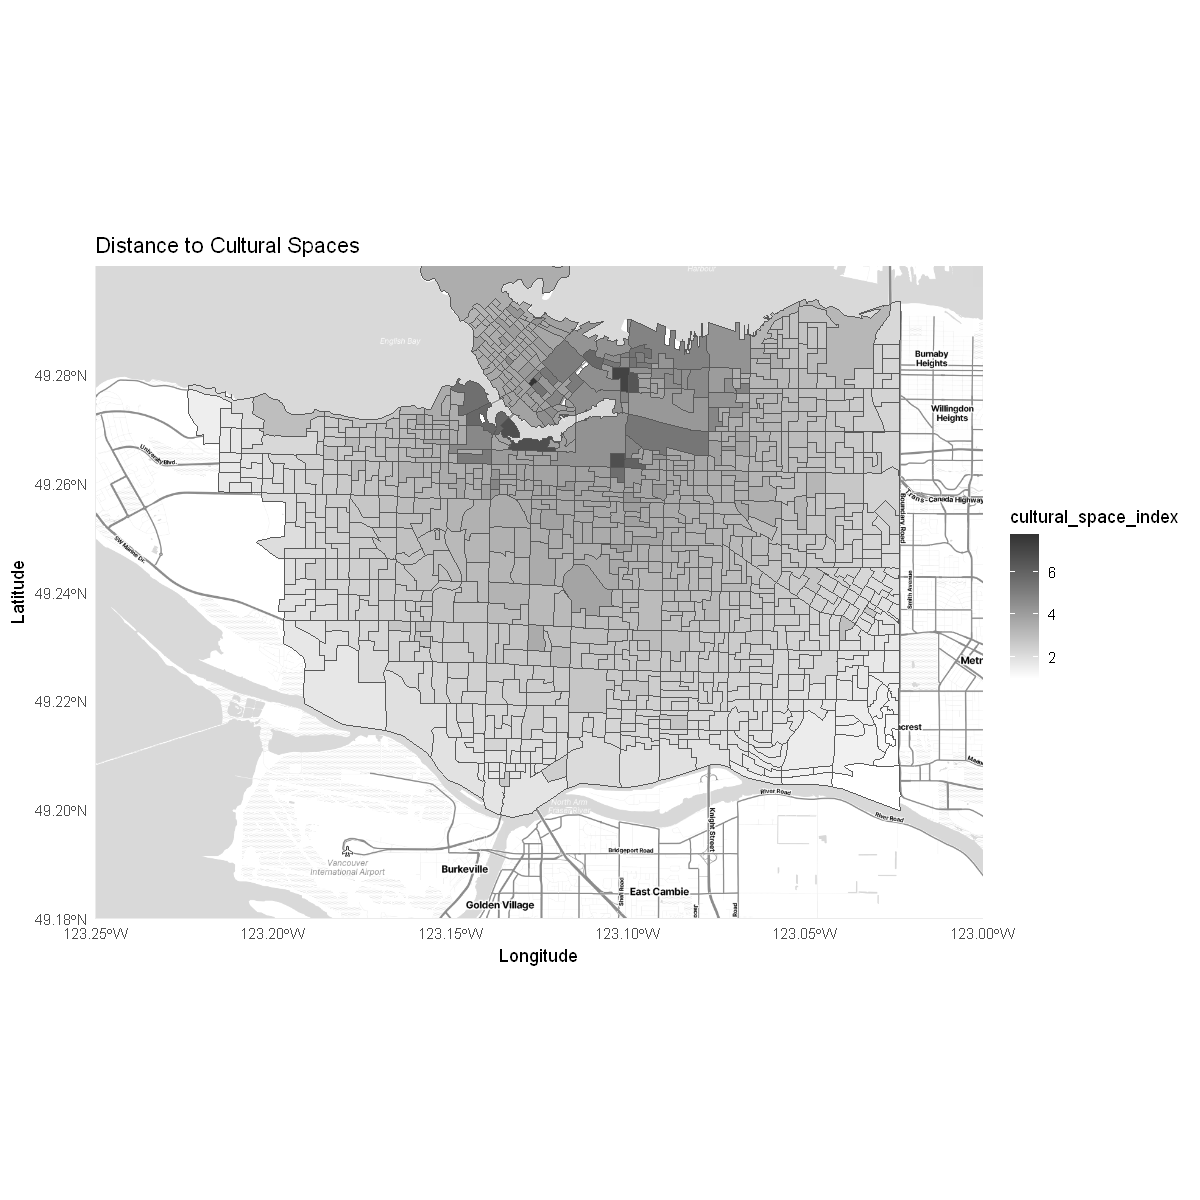

In [189]:
# Add visualization for cultural space index data

options(repr.plot.width = 10, repr.plot.height = 10)


mean_cs_value_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = cultural_space_index), inherit.aes = FALSE) +
  scale_fill_viridis_c(option = "plasma", name = "Mean Land Value") +
  coord_sf(crs = st_crs(4326)) +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  theme_minimal() +
  labs(title = "Distance to Cultural Spaces", x = "Longitude", y = "Latitude")

mean_cs_value_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


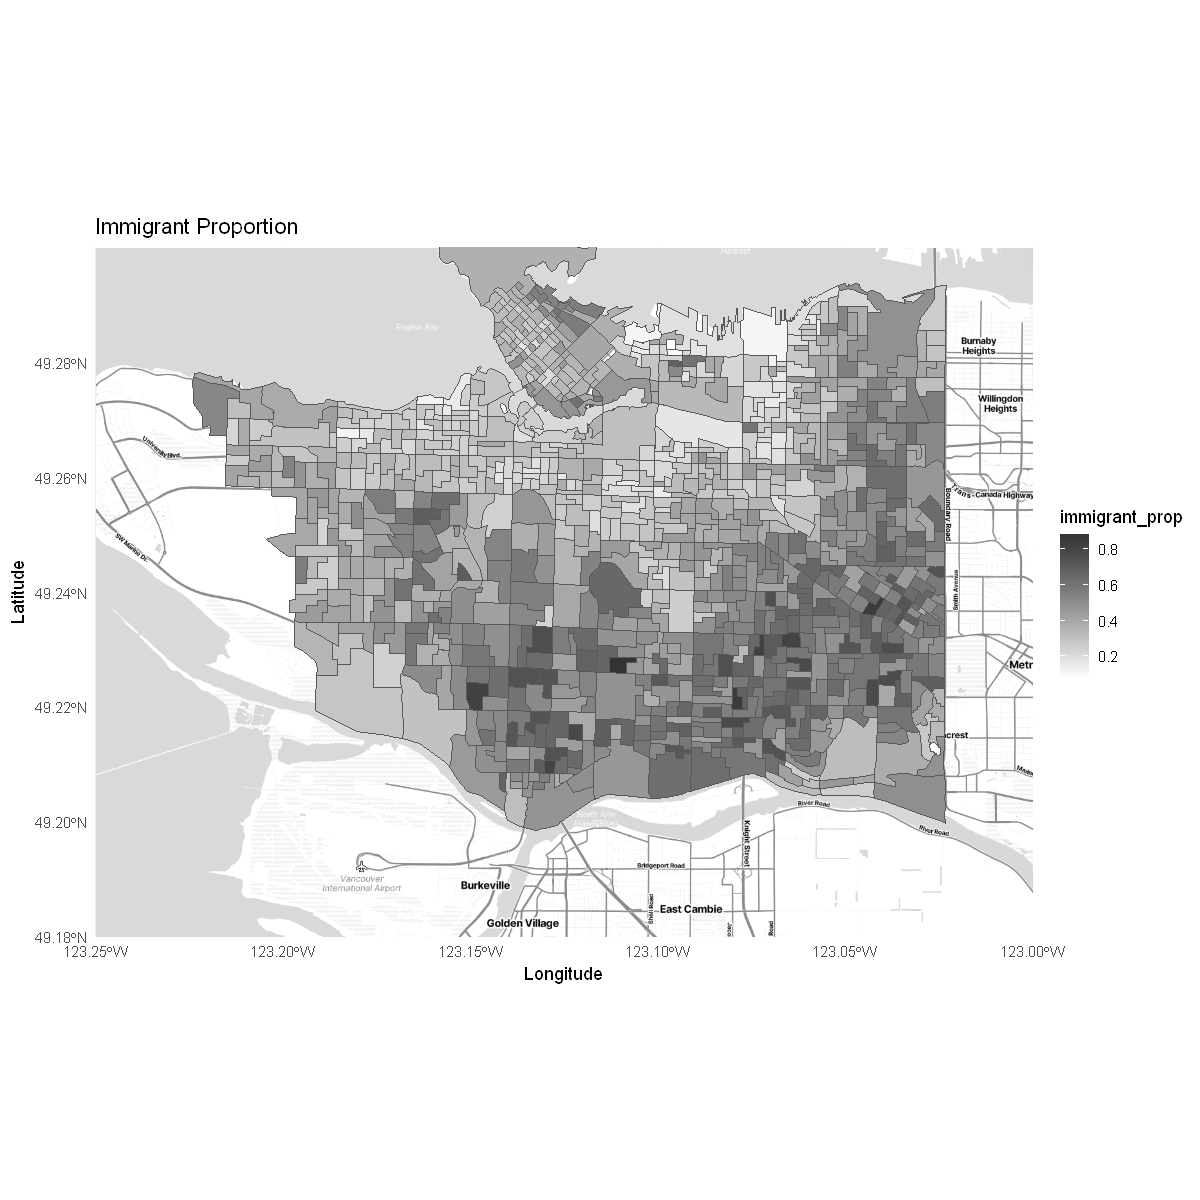

In [190]:
# Add visualization for eimmigrant data

options(repr.plot.width = 10, repr.plot.height = 10)


mean_education_value_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = immigrant_prop), inherit.aes = FALSE) +
  scale_fill_viridis_c(option = "plasma", name = "Mean Land Value") +
  coord_sf(crs = st_crs(4326)) +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  theme_minimal() +
  labs(title = "Immigrant Proportion", x = "Longitude", y = "Latitude")

mean_education_value_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


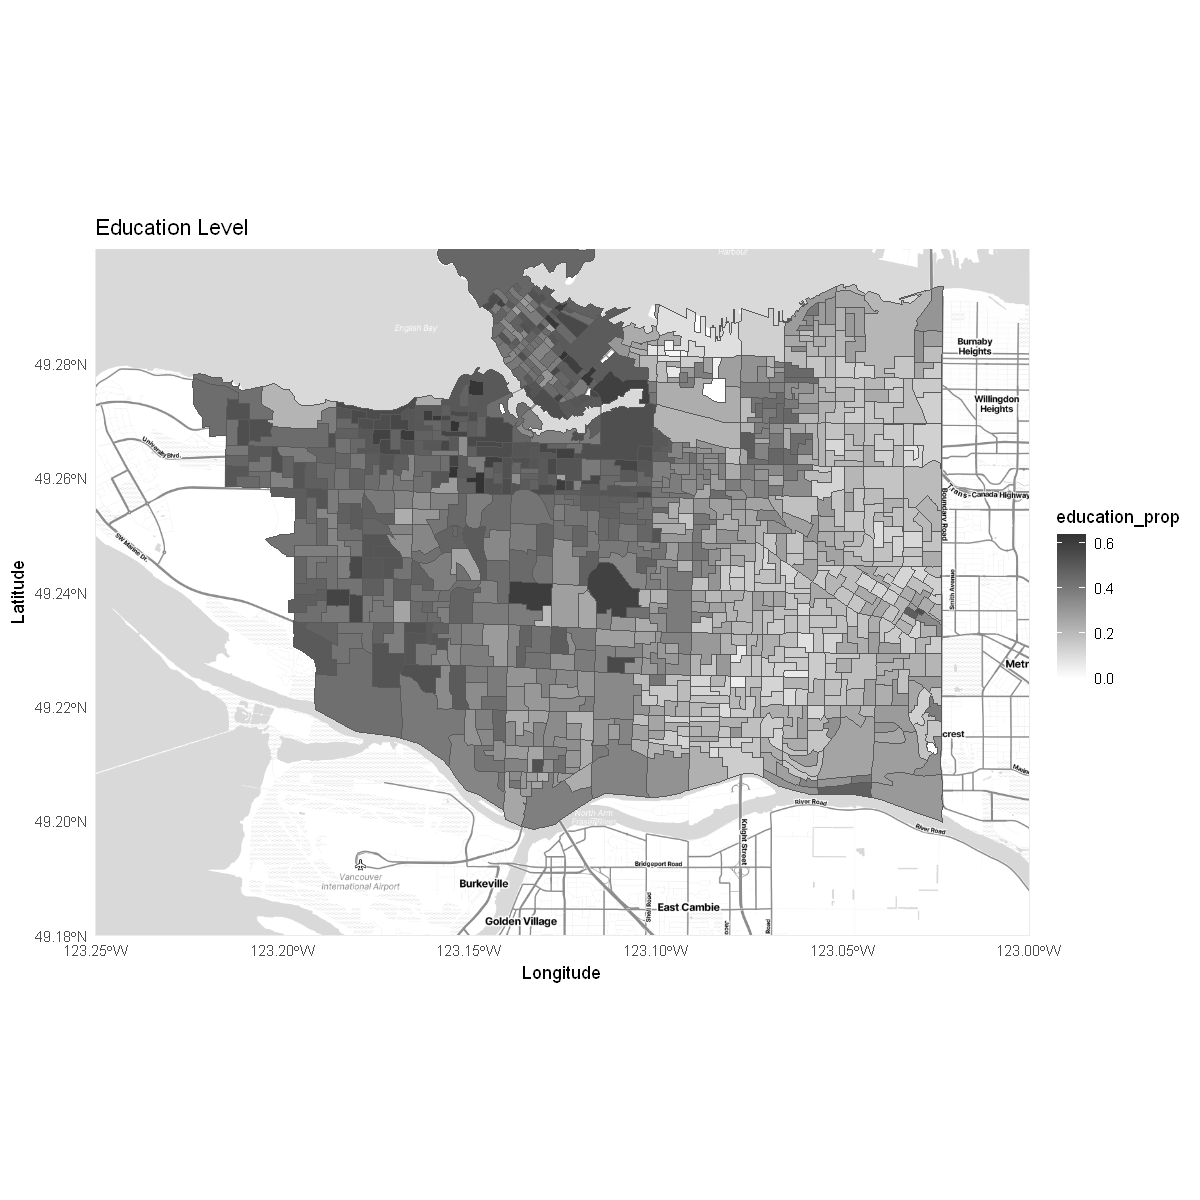

In [191]:
# Add visualization for education data

options(repr.plot.width = 10, repr.plot.height = 10)


mean_education_value_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = education_prop), inherit.aes = FALSE) +
  scale_fill_viridis_c(option = "plasma", name = "Mean Land Value") +
  coord_sf(crs = st_crs(4326)) +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  theme_minimal() +
  labs(title = "Education Level", x = "Longitude", y = "Latitude")

mean_education_value_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


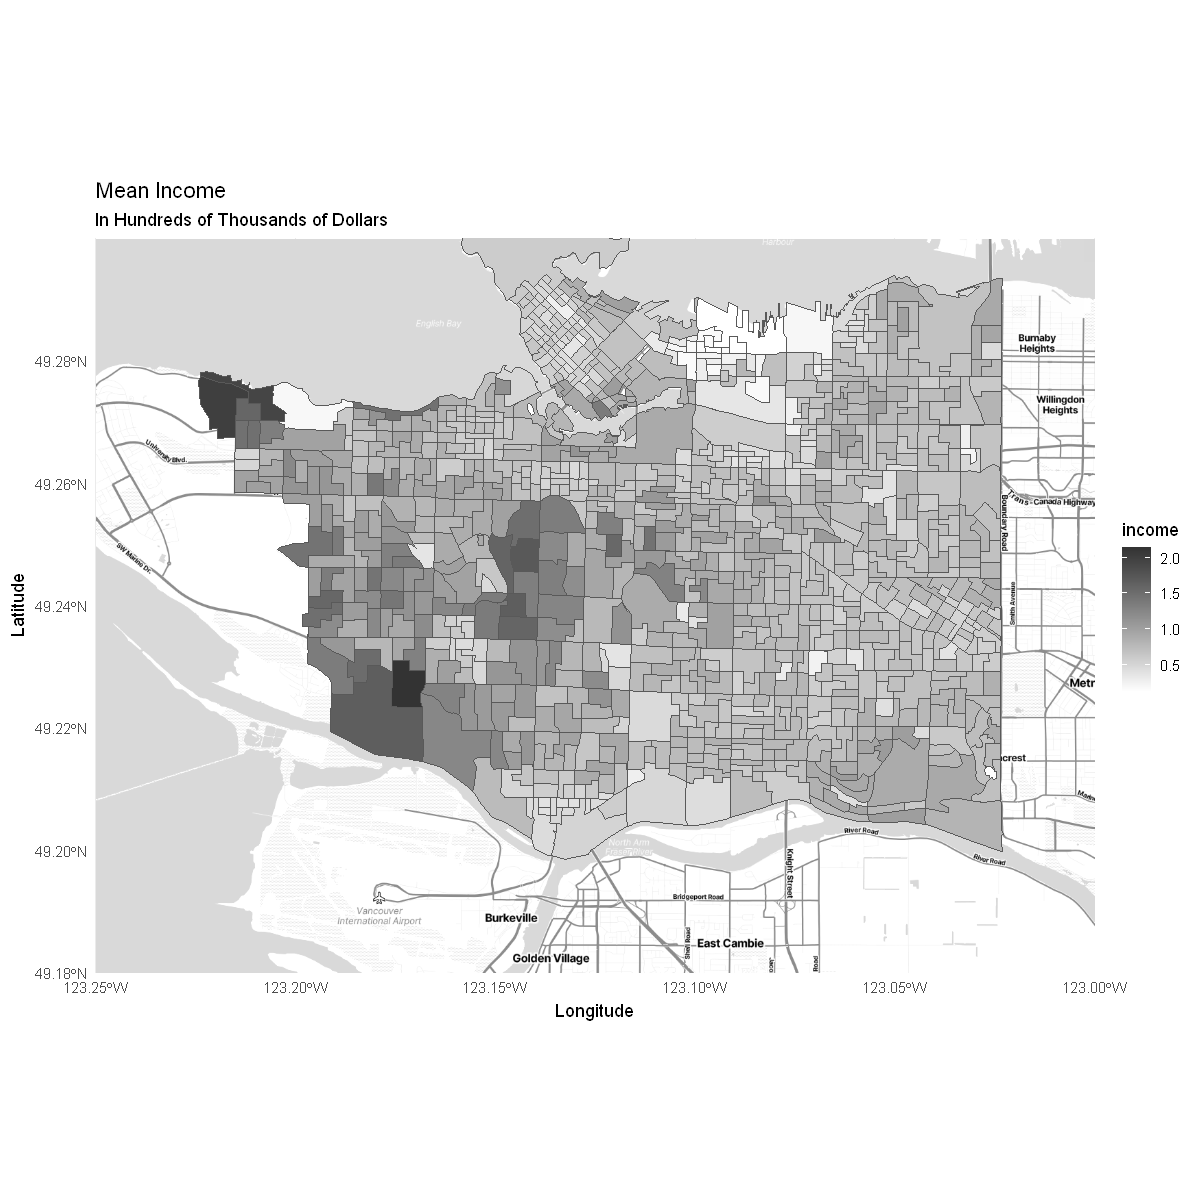

In [192]:
# Add visualization for income value data

options(repr.plot.width = 10, repr.plot.height = 10)


mean_income_value_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = income), inherit.aes = FALSE) +
  scale_fill_viridis_c(option = "plasma", name = "Mean Land Value") +
  coord_sf(crs = st_crs(4326)) +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  theme_minimal() +
  labs(title = "Mean Income", subtitle = "In Hundreds of Thousands of Dollars", x = "Longitude", y = "Latitude")

mean_income_value_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


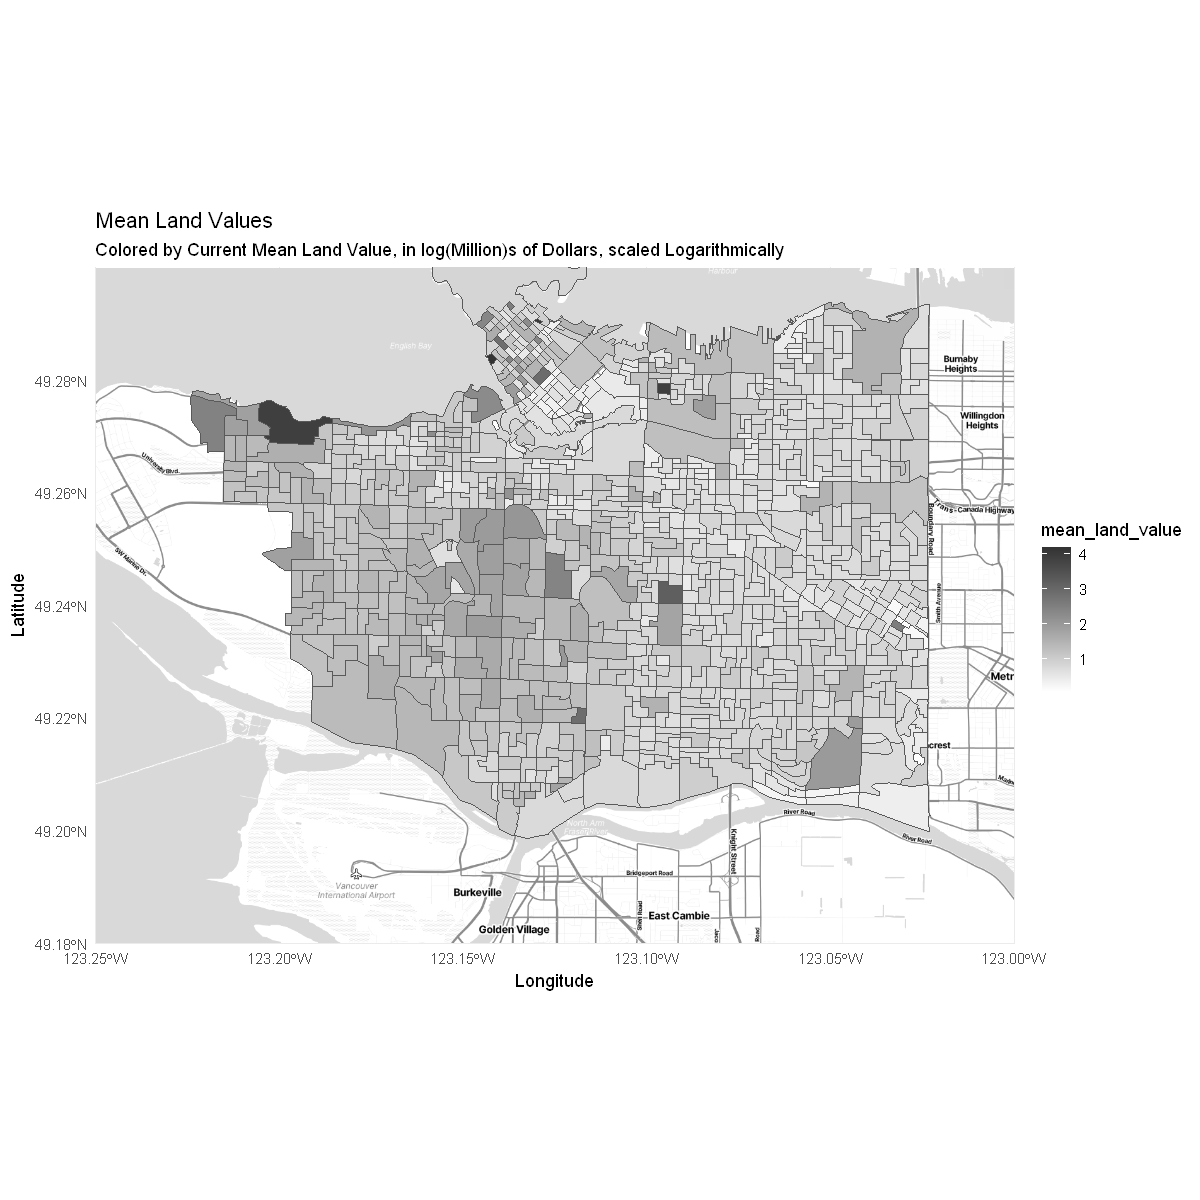

In [193]:
# Add visualization for mean land value data

options(repr.plot.width = 10, repr.plot.height = 10)


mean_land_value_map <- ggmap(base) +
  geom_sf(data = census_index_crime_graphs, aes(fill = mean_land_value), inherit.aes = FALSE) +
  scale_fill_viridis_c() +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Mean Land Values", subtitle = "Colored by Current Mean Land Value, in log(Million)s of Dollars, scaled Logarithmically",
  x = "Longitude", y = "Latitude")

mean_land_value_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


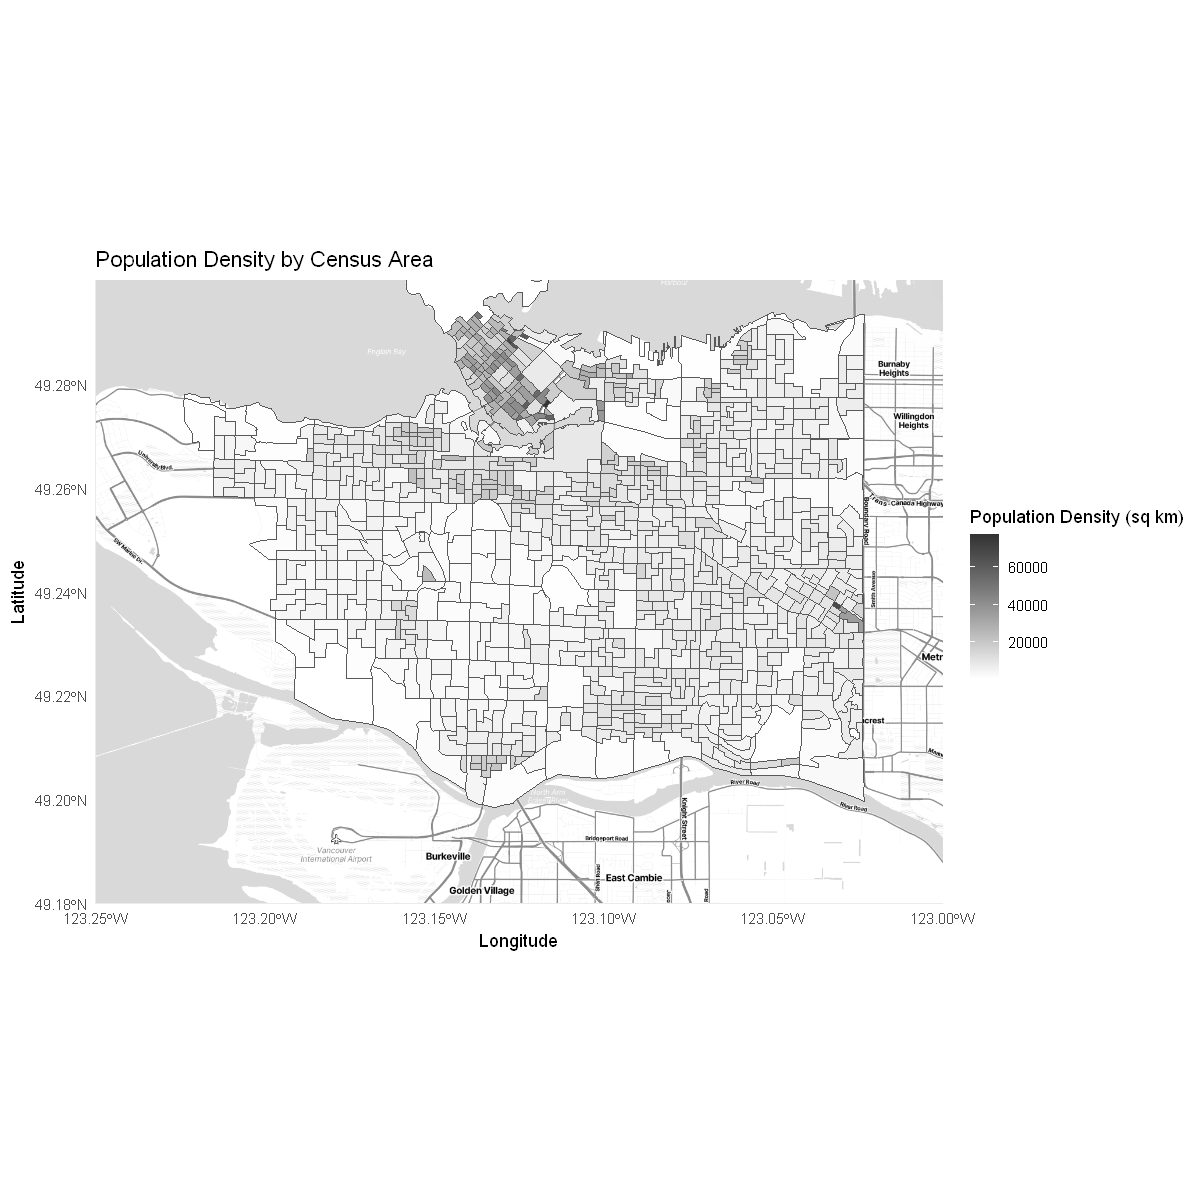

In [194]:
# Add visualization for population density data
density_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = population_density),inherit.aes = FALSE) +
  scale_fill_viridis_c() +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Population Density by Census Area", fill = "Population Density (sq km)", x = "Longitude", y = "Latitude")

density_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


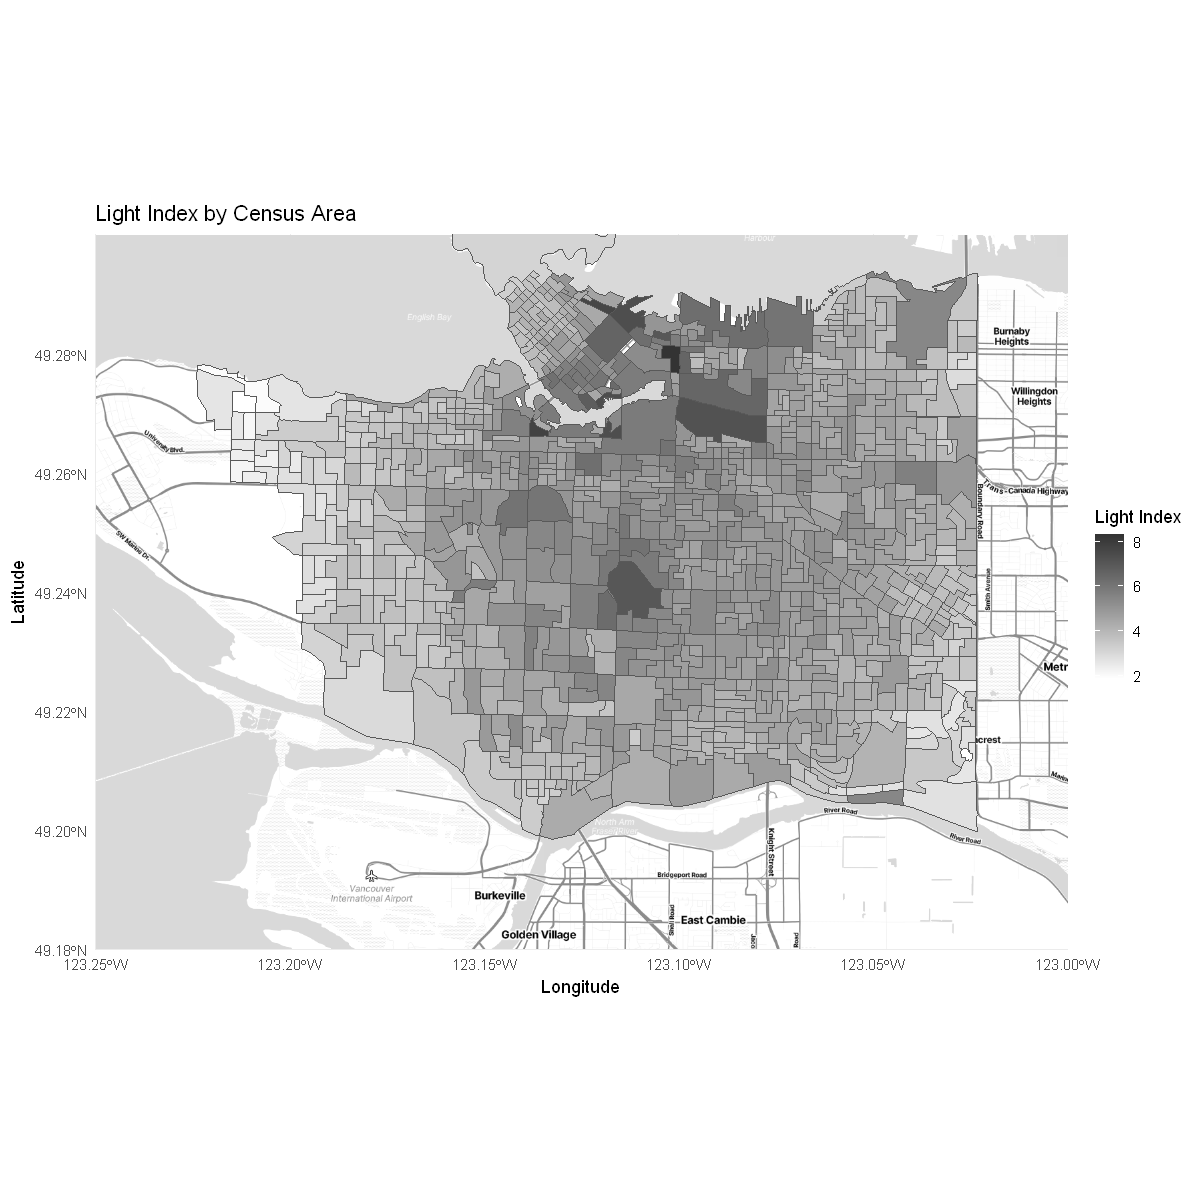

In [195]:
# Add visualization for light index data
light_index_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = light_index),inherit.aes = FALSE) +
 scale_fill_viridis_c() +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Light Index by Census Area", fill = "Light Index", x = "Longitude", y = "Latitude")

light_index_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


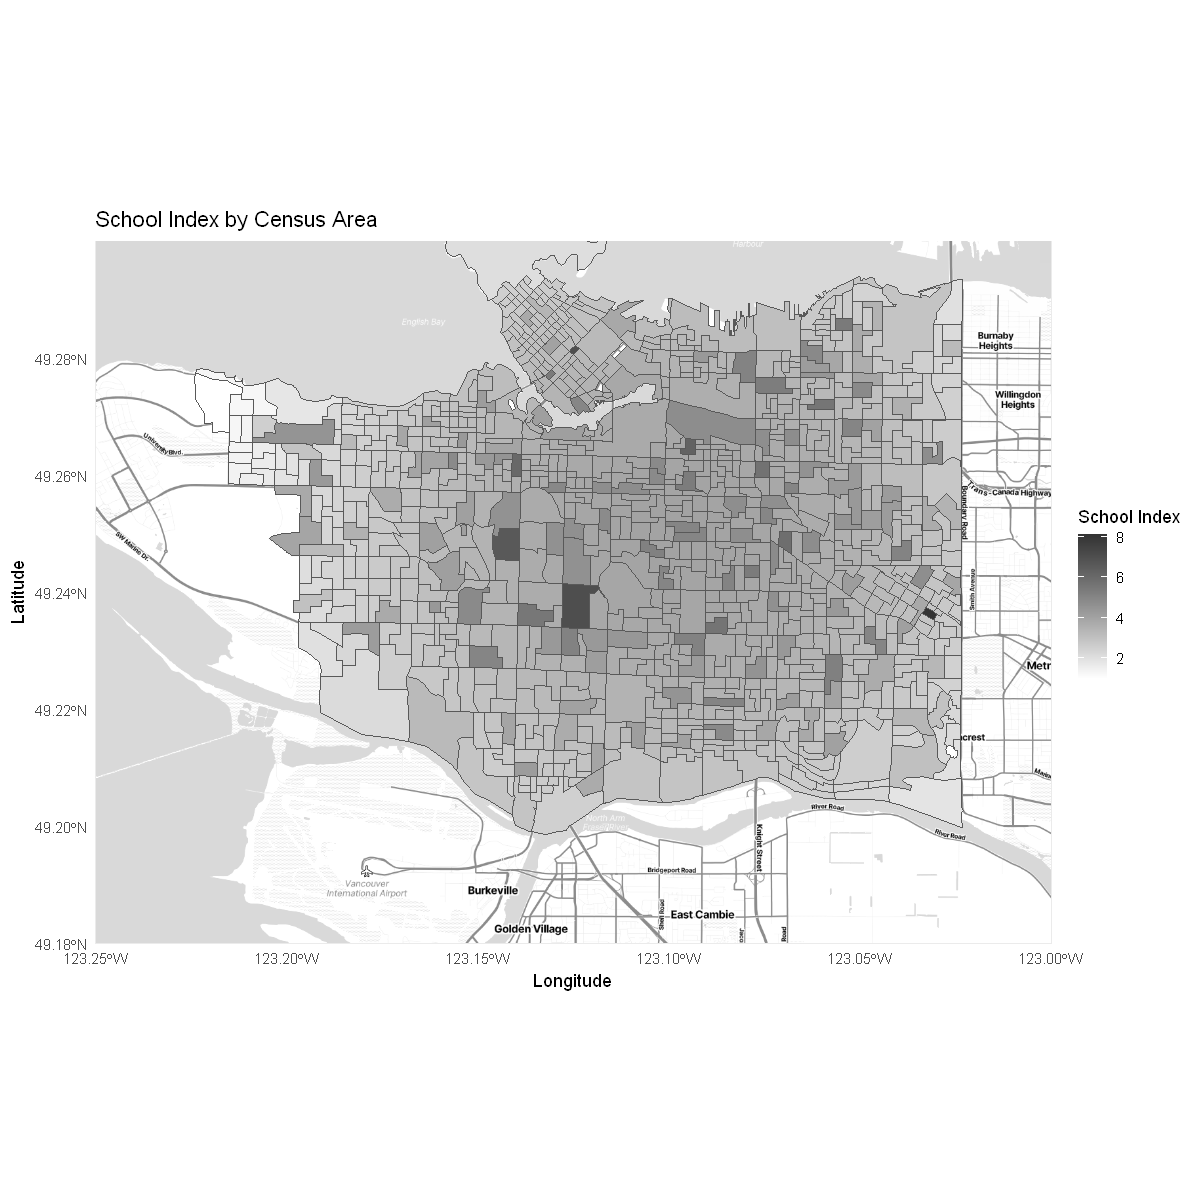

In [196]:
# Add visualization for school index data
school_index_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = school_index),inherit.aes = FALSE) +
 scale_fill_viridis_c() +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "School Index by Census Area", fill = "School Index", x = "Longitude", y = "Latitude")

school_index_map

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


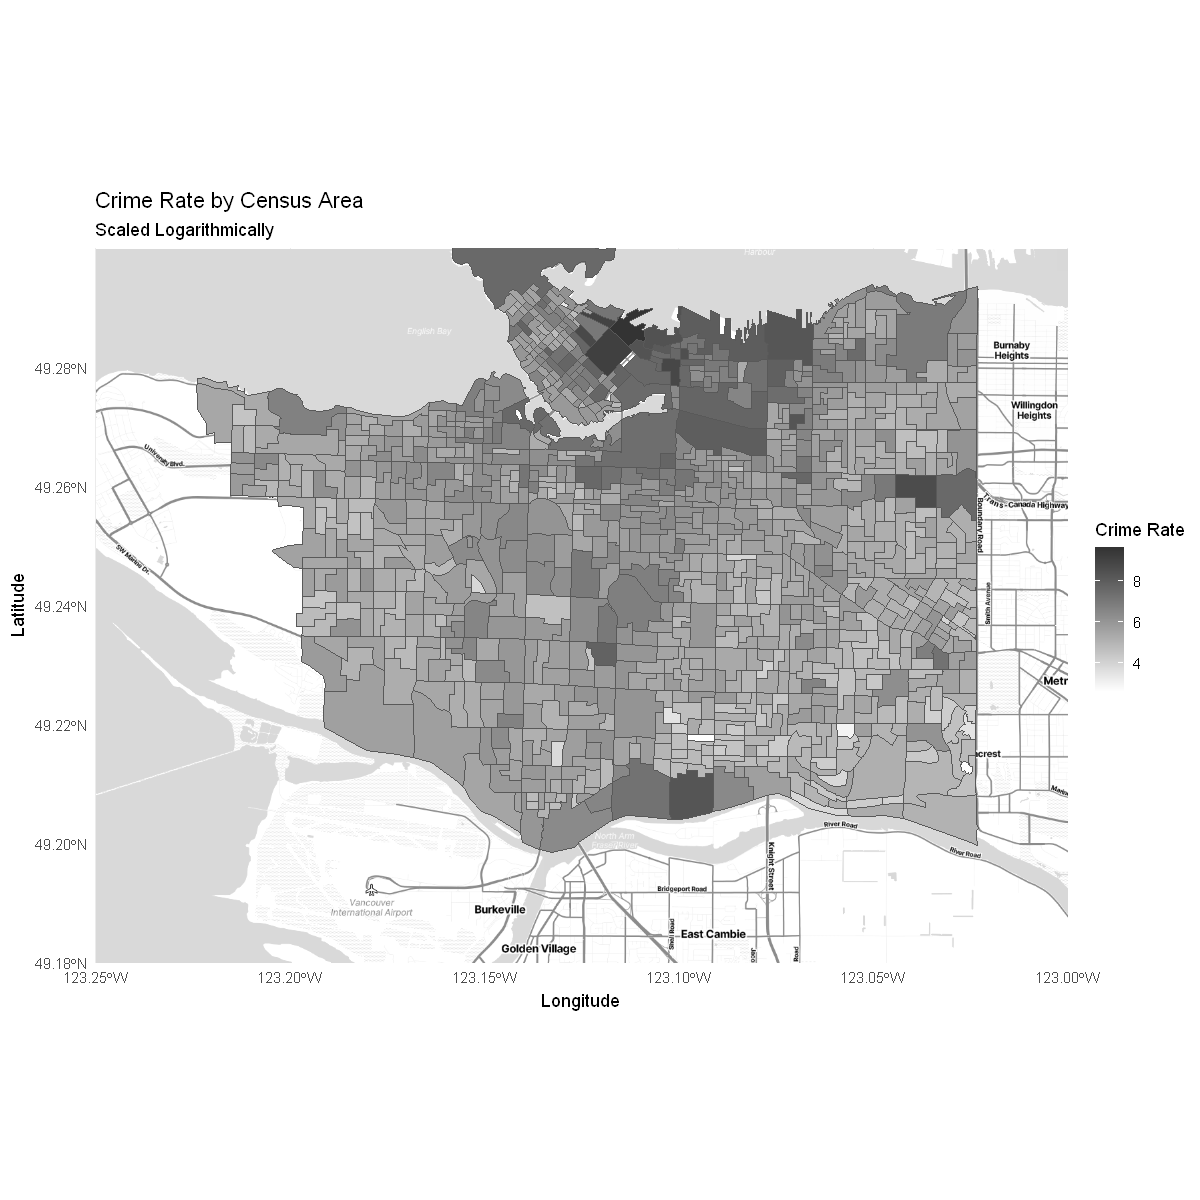

In [197]:
crime_rate_map <- ggmap(base) +
  geom_sf(data = census_index_crime, aes(fill = log(crime_rate)),inherit.aes = FALSE) +
 scale_fill_viridis_c() +
  scale_fill_gradient(low = "#ffffff", high = "#333333") +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Crime Rate by Census Area", subtitle = "Scaled Logarithmically", fill = "Crime Rate", x = "Longitude", y = "Latitude")

crime_rate_map

### Summary statistics table

In [198]:
sum_stats <- function(column) {
    col_name <- deparse(substitute(column))
    col_name <- gsub(".*\\$", "", col_name)

    dataframe = data.frame(mean = round(mean(column), 3),
                            standard_dev = round(sd(column), 3),
                            max = round(max(column), 3),
                            min = round(min(column), 3),
                            col_name = col_name)
    return(dataframe)}

In [199]:
options(scipen = 9999)

income <- sum_stats(census_index_crime$income)
age <- sum_stats(census_index_crime$age)
immigrant_prop <- sum_stats(census_index_crime$immigrant_prop)
education_prop <- sum_stats(census_index_crime$education_prop)
school_index <- sum_stats(census_index_crime$school_index)
light_index <- sum_stats(census_index_crime$light_index)
bus_index <- sum_stats(census_index_crime$bus_index)
cultural_space_index <- sum_stats(census_index_crime$cultural_space_index)
crime_count <- sum_stats(census_index_crime$crime_count)
crime_rate <- sum_stats(census_index_crime$crime_rate)
mean_land_value  <- sum_stats(census_index_crime$mean_land_value)

summary_statistics <- rbind(income, age, immigrant_prop, education_prop, school_index,
                            light_index, bus_index, cultural_space_index, crime_count,
                            crime_rate, mean_land_value)

summary_statistics

mean,standard_dev,max,min,col_name
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.730,0.248,2.135,0.127,income
41.700,4.404,84.200,32.100,age
0.417,0.150,0.880,0.078,immigrant_prop
0.336,0.135,0.637,0.000,education_prop
3.363,0.729,8.119,1.000,school_index
4.415,0.802,8.314,1.894,light_index
3.627,0.707,6.995,1.263,bus_index
2.999,0.850,7.732,1.000,cultural_space_index
34.886,117.082,2731.000,1.000,crime_count


In [200]:
summary_statistics |>
  kbl(caption="Table 1: Summary Statistics of Regression Variables",
       format= "latex",
   col.names = c('mean', 'standard_dev','max','min', 'col_name'),
                  align="r") |>
   kable_classic(full_width = F, html_font = "helvetica")

\begin{table}
\centering
\caption{Table 1: Summary Statistics of Regression Variables}
\centering
\begin{tabular}[t]{r|r|r|r|r}
\hline
mean & standard\_dev & max & min & col\_name\\
\hline
0.730 & 0.248 & 2.135 & 0.127 & income\\
\hline
41.700 & 4.404 & 84.200 & 32.100 & age\\
\hline
0.417 & 0.150 & 0.880 & 0.078 & immigrant\_prop\\
\hline
0.336 & 0.135 & 0.637 & 0.000 & education\_prop\\
\hline
3.363 & 0.729 & 8.119 & 1.000 & school\_index\\
\hline
4.415 & 0.802 & 8.314 & 1.894 & light\_index\\
\hline
3.627 & 0.707 & 6.995 & 1.263 & bus\_index\\
\hline
2.999 & 0.850 & 7.732 & 1.000 & cultural\_space\_index\\
\hline
34.886 & 117.082 & 2731.000 & 1.000 & crime\_count\\
\hline
460.524 & 841.972 & 15000.000 & 13.908 & crime\_rate\\
\hline
1.942 & 3.814 & 64.832 & 0.063 & mean\_land\_value\\
\hline
\end{tabular}
\end{table}

# Linear Regression

### Residuals visualization

In [201]:
fn_residuals <- function(data, dependent_vars, independent_var) {
  
residuals_list <- list() #empty accumulator list

# looping through each variable and calcualting residuals
  for (var in dependent_vars) {
   formula <- as.formula(paste(var, "~", independent_var)) # https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/formula
    model <- lm(formula, data = data)
    residuals_list[[var]] <- resid(model) # extracting residuals and assigning to empty list
  }
  
  residuals_df <- as.data.frame(residuals_list)
  colnames(residuals_df) <- paste0("residual_", dependent_vars)

residuals_df <- cbind(residuals_df, data[dependent_vars]) |>
select(!geometry)

 return(residuals_df)}

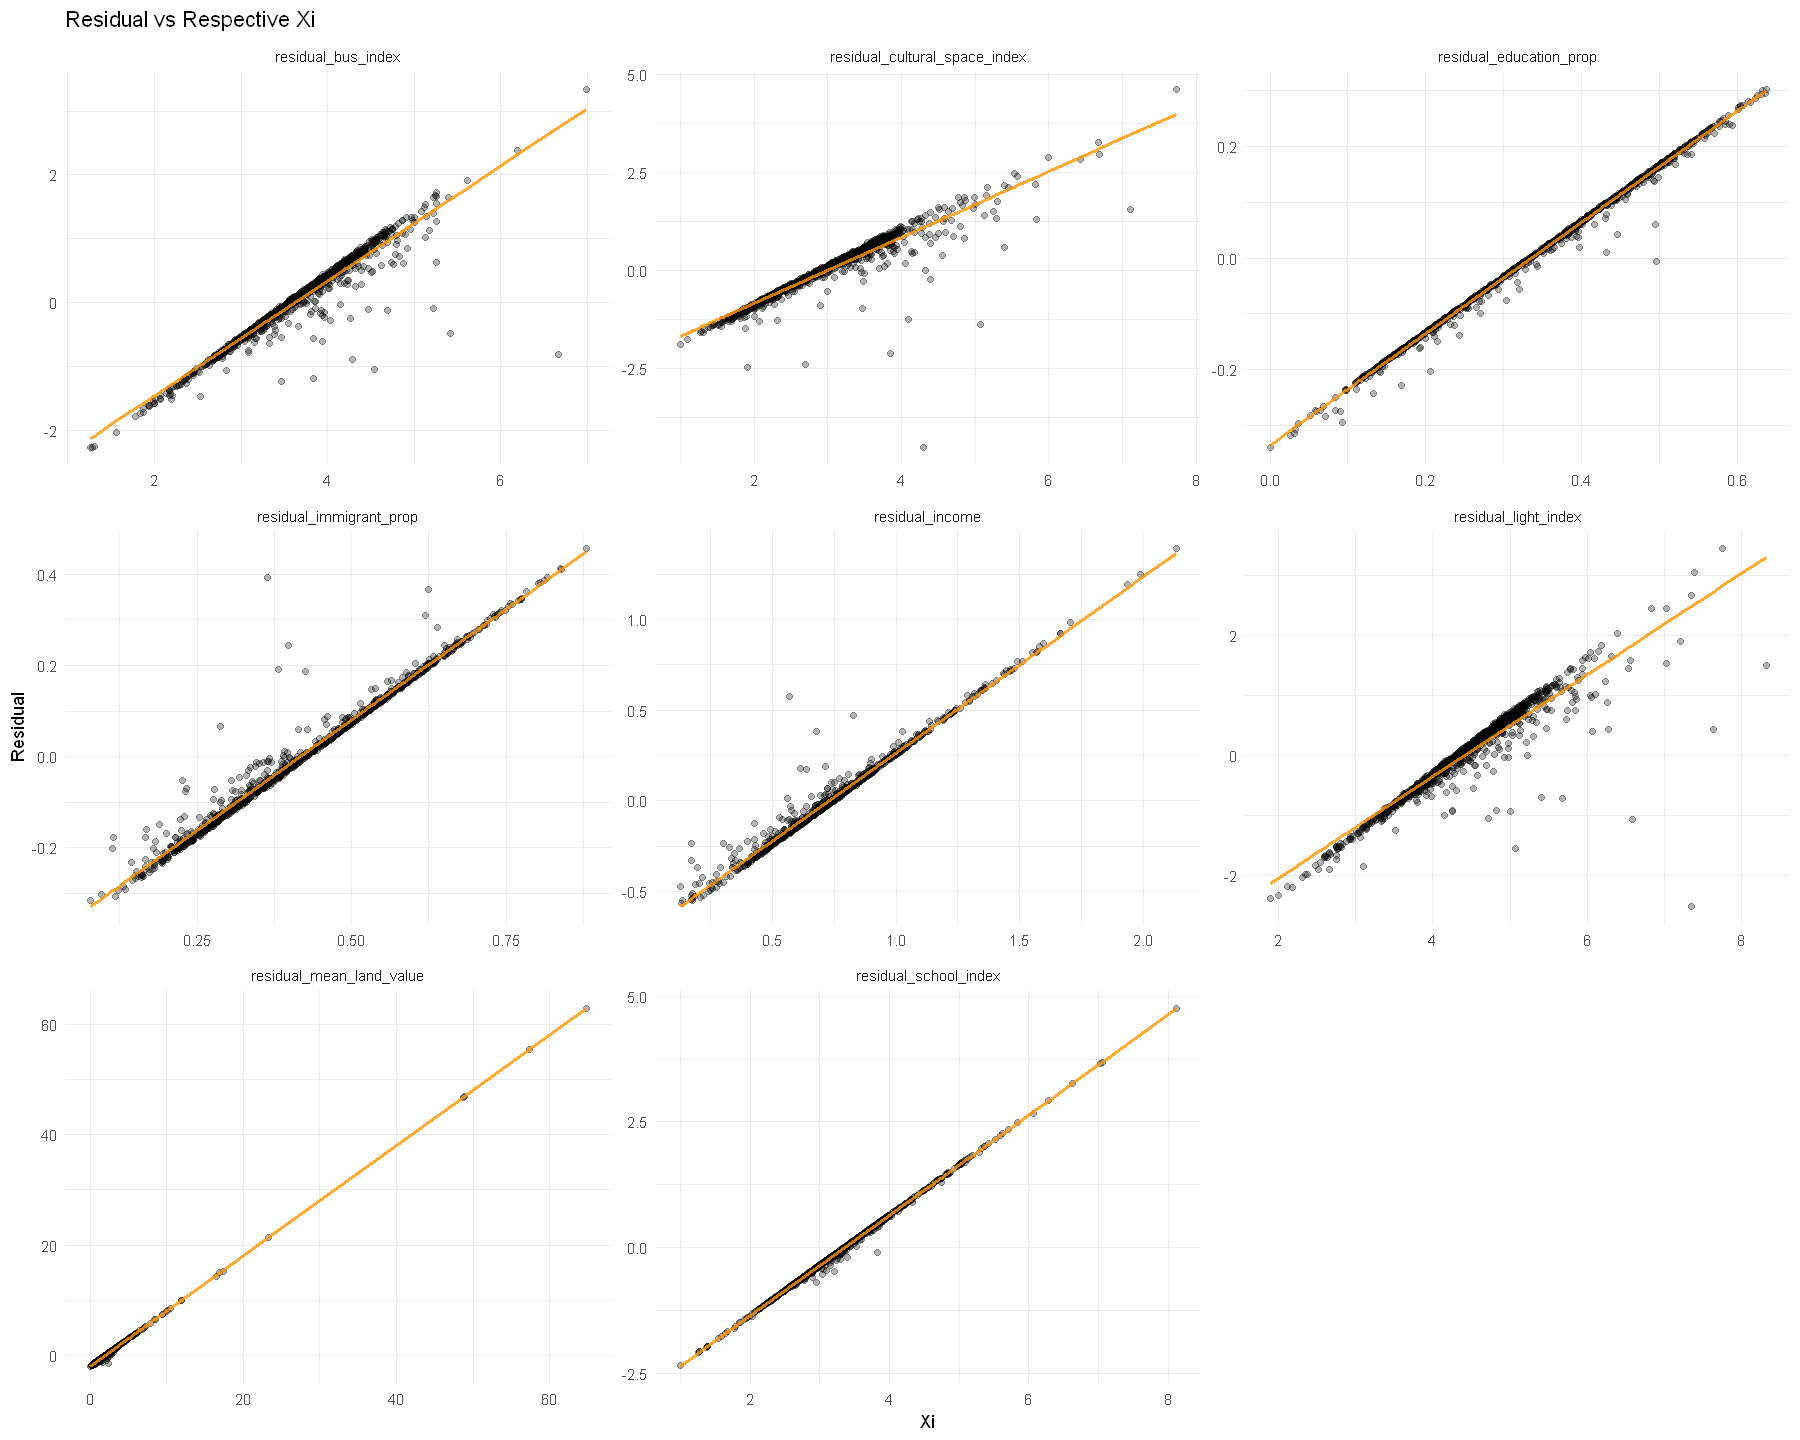

In [202]:
dependent_vars <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
residuals_df <- fn_residuals(census_index_crime, dependent_vars, "crime_rate")

residuals_long <- residuals_df |>
  pivot_longer(
    cols = starts_with("residual_"), names_to = "residual_type", values_to = "residual_value") |>
  mutate(x_value = case_when(
    residual_type == "residual_mean_land_value" ~ mean_land_value,
    residual_type == "residual_school_index" ~ school_index,
    residual_type == "residual_light_index" ~ light_index,
    residual_type == "residual_bus_index" ~ bus_index,
    residual_type == "residual_cultural_space_index" ~ cultural_space_index,
    residual_type == "residual_income" ~ income,
    residual_type == "residual_immigrant_prop" ~ immigrant_prop,
    residual_type == "residual_education_prop" ~ education_prop
  ))

  options(repr.plot.width = 15, repr.plot.height = 12)

residuals_long  <- residuals_long |>
  group_by(residual_type) |>
  mutate(
    model = list(lm(residual_value ~ x_value, data = cur_data())),
    fitted_values = predict(model[[1]], newdata = data.frame(x_value = x_value))
  ) |>
  ungroup()

ggplot(residuals_long, aes(x = x_value, y = residual_value)) +
  geom_point(alpha=0.3) +
  geom_line(aes(y = fitted_values), color = "#ff9500", size=1, alpha=0.8) +  
  facet_wrap(~ residual_type, scales = "free") +
  labs(
    title = "Residual vs Respective Xi",
    x = "Xi",
    y = "Residual"
  ) +
  theme_minimal()

Simple regressions and visualizations

`geom_smooth()` using formula = 'y ~ x'


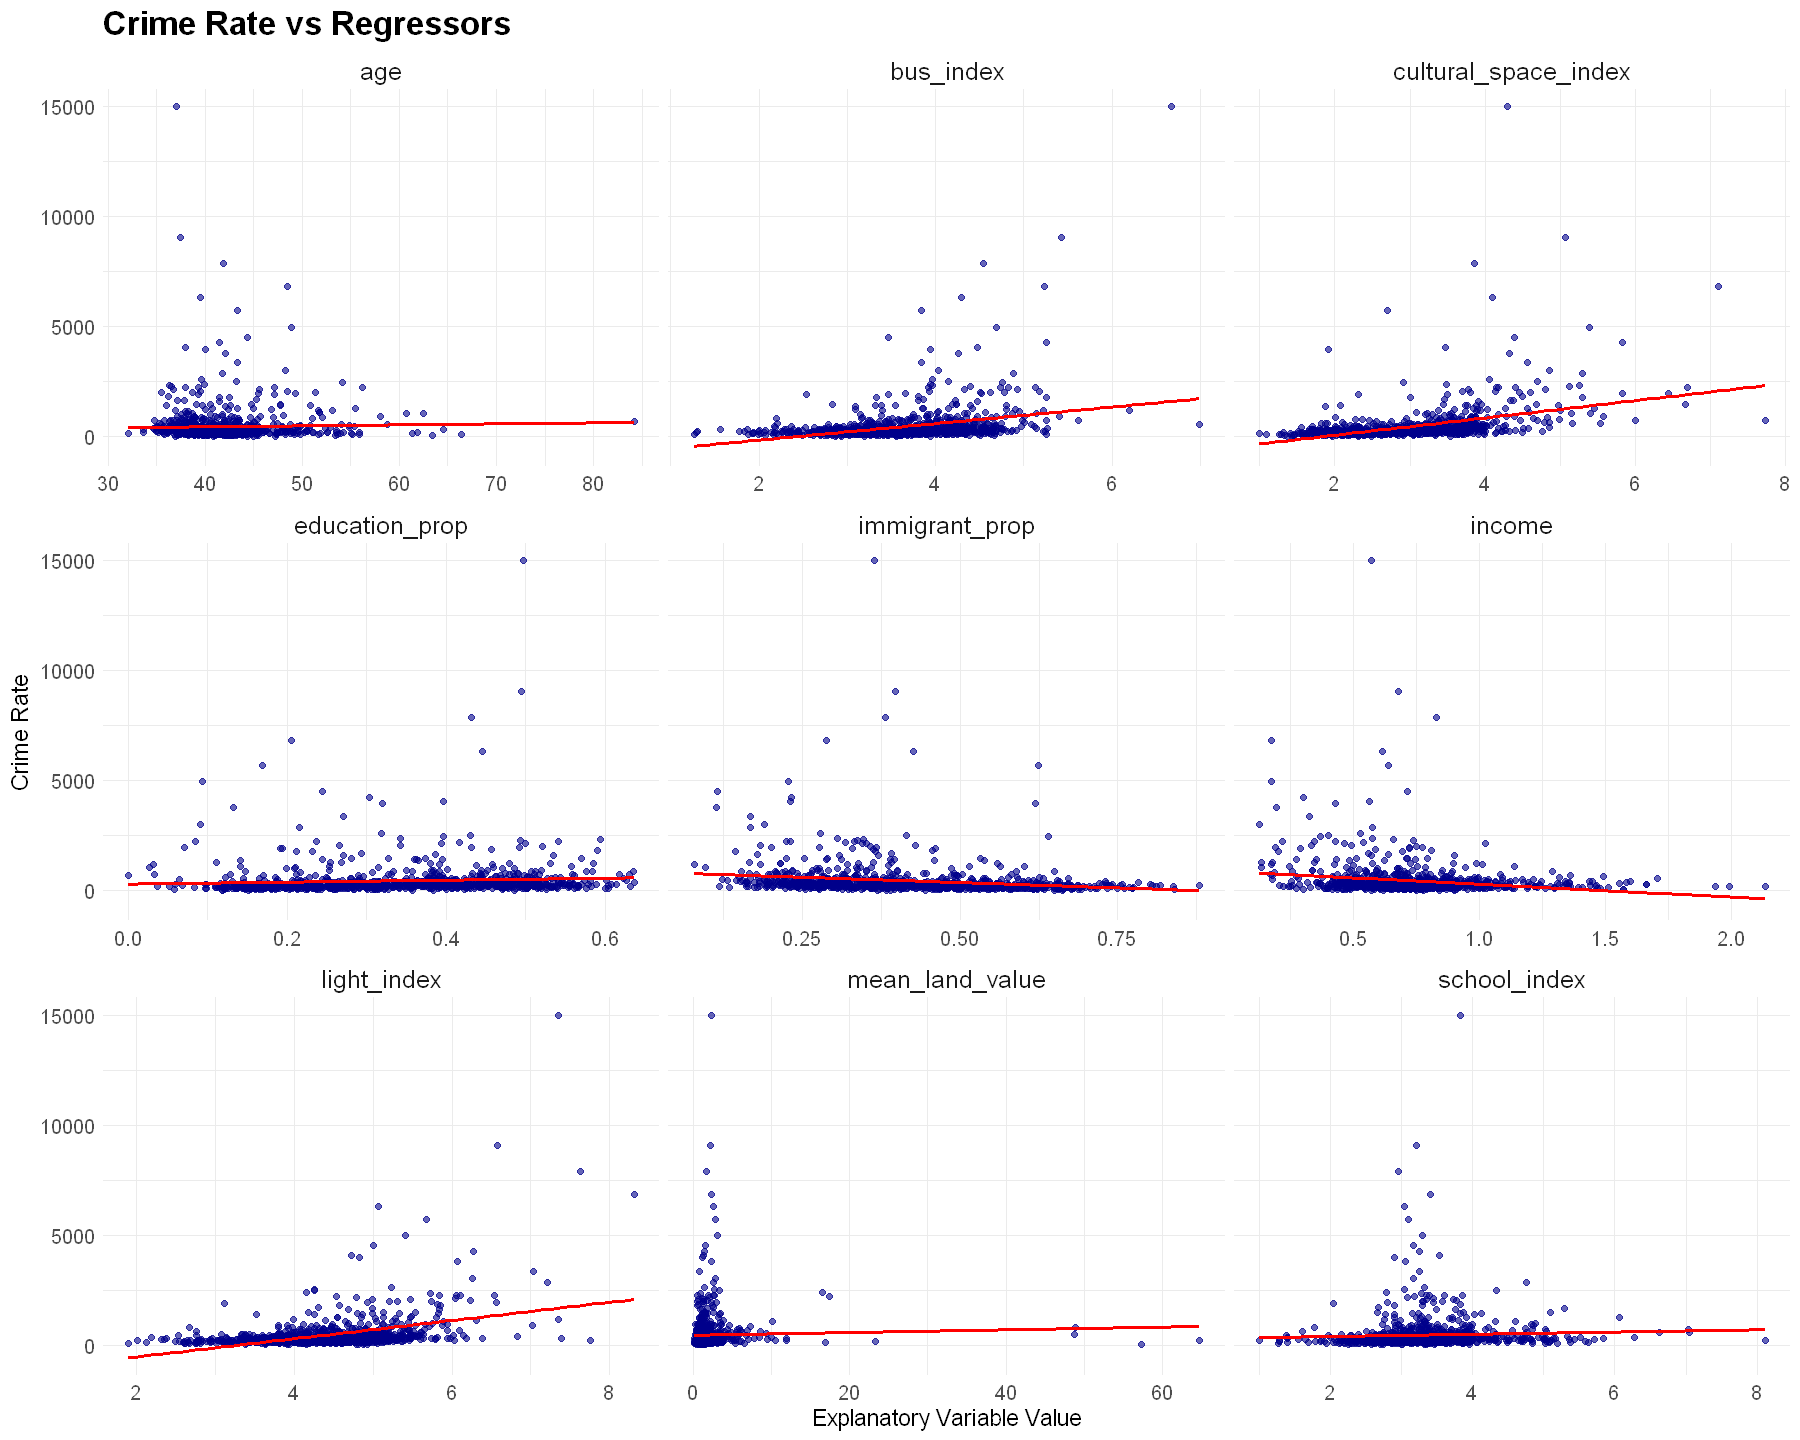

In [239]:
regressors <- c('light_index', 'age', 'mean_land_value','school_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

variables_regression_scatter <- ggplot(long_data, aes(x = value, y = crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  labs(title = "Crime Rate vs Regressors",
       x = "Explanatory Variable Value",
       y = "Crime Rate") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))
        
variables_regression_scatter

In [240]:
# Carry out all the simple regressions
outcome <- "crime_rate"

simple_regressions <- map(regressors, ~ lm(as.formula(paste(outcome, "~", .x)), data = census_index_crime))

names(simple_regressions) <- regressors

stargazer(simple_regressions, type = "text",
          title = "Simple Regression Results",
          dep.var.labels = c("Crime Rate"))


Simple Regression Results
                                                                         Dependent variable:                                          
                               -------------------------------------------------------------------------------------------------------
                                                                             Crime Rate                                               
                                    (1)         (2)       (3)        (4)        (5)         (6)         (7)         (8)        (9)    
--------------------------------------------------------------------------------------------------------------------------------------
light_index                     413.199***                                                                                            
                                 (30.724)                                                                                             
                            

 ### log-log Regression Models 

In [205]:
# Identify variables with zeros
zero_counts <- sapply(census_index_crime, function(x) {
  if (is.numeric(x)) {
    sum(x == 0, na.rm = TRUE)
  } else {
    NA
  }
})
print("Variables with zero counts:")
print(zero_counts)

[1] "Variables with zero counts:"
                name           households            dwellings 
                  NA                    0                    0 
          population   population_density               region 
                   0                    0                   NA 
          area_sq_km                  age               income 
                   0                    0                    0 
      immigrant_prop       education_prop         school_index 
                   0                    1                    0 
         light_index            bus_index cultural_space_index 
                   0                    0                    0 
     mean_land_value          crime_count           crime_rate 
                   0                    0                    0 
            geometry 
                  NA 


In [241]:
# log transformation for variables other than immigrant_prop and education_prop
census_index_crime_log <- census_index_crime |> 
  mutate(
    log_crime_rate = log(crime_rate),
    log_mean_land_value = log(mean_land_value),
    log_school_index = log(school_index),
    log_light_index = log(light_index),
    log_bus_index = log(bus_index),
    log_cultural_space_index = log(cultural_space_index),
    log_income = log(income),
    immigrant_prop = immigrant_prop,  
    education_prop = education_prop 
  )|>
  glimpse()


Rows: 989
Columns: 26
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <fct> Vancouver, Vancouver, Vancouver, Vancouver, V…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

In [242]:
# Conduct a regression on log(light index) only
reg_log_simple <- lm(log_crime_rate ~  log_light_index,
              data = census_index_crime_log)

white_test <- bptest(reg_log_simple, ~ fitted(reg_log_simple) + I(fitted(reg_log_simple)^2), data = census_index_crime_log)
print(white_test) 

robust_se_simple <- sqrt(diag(vcovHC(reg_log_simple, type = "HC1")))

stargazer(reg_log_simple, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se_simple),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log_simple
BP = 64.324, df = 2, p-value = 0.00000000000001077




Log-Log Regression Results with Robust Standard Errors
                        Dependent variable:    
                    ---------------------------
                          Log Crime Rate       
-----------------------------------------------
log_light_index          1.790*** (0.154)      
Constant                 3.052*** (0.221)      
-----------------------------------------------
Observations                    989            
R2                             0.168           
Adjusted R2                    0.168           
Residual Std. Error      0.745 (df = 987)      
F Statistic          199.787*** (df = 1; 987)  
Note:               *p<0.1; **p<0.05; ***p<0.01


We shift to using log(light count) instead for research topic concern.

In [208]:
light_data <- get_cov_data(dataset_id = 'street-lighting-poles')|>
    st_sf()

Reading data from temporary cache



In [243]:
# Merge light counts back into the census dataset
census_index_crime_log <- st_sf(census_index_crime_log)|>
    st_make_valid()

light_data <- st_transform(light_data, st_crs(census_index_crime_log))

lights_with_census <- st_join(light_data, census_index_crime_log, join = st_within)

light_counts <- lights_with_census %>%
    st_drop_geometry() %>% 
    group_by(name) %>%     
    summarize(light_count = n(), .groups = "drop")

census_index_crime_log <- census_index_crime_log %>%
    left_join(light_counts, by = "name") %>%
    mutate(light_count = replace_na(light_count, 0))|>
    mutate(log_light_count = log(if_else(light_count == 0, 0.01, light_count))) # Fill missing values with 0

glimpse(census_index_crime_log)

Rows: 989
Columns: 28
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <fct> Vancouver, Vancouver, Vancouver, Vancouver, V…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


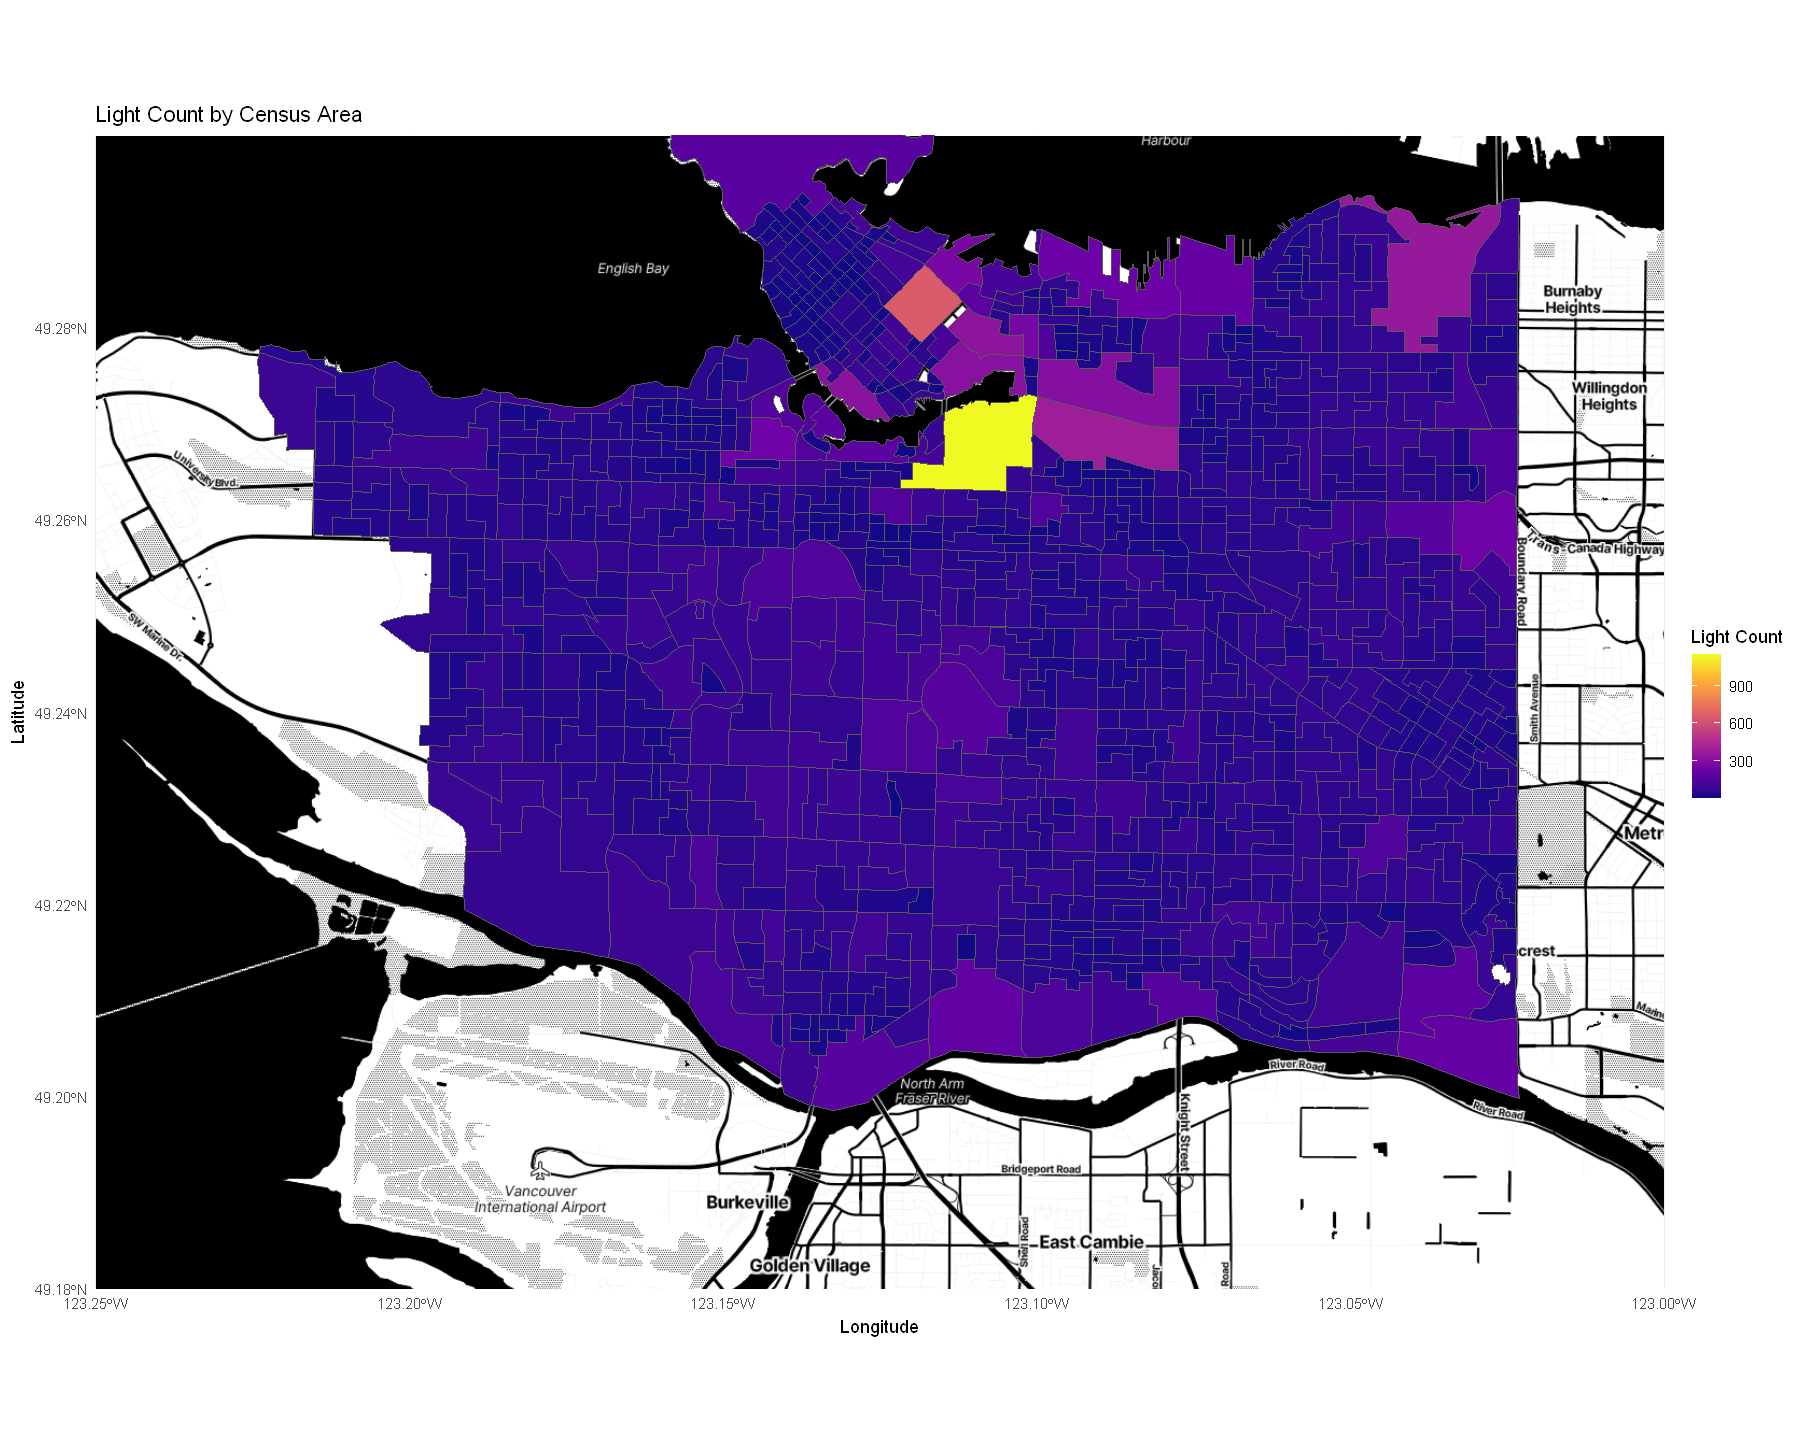

In [210]:
# Add visualization for light count data
light_count_map <- ggmap(map) +
  geom_sf(data = census_index_crime_log, aes(fill = light_count),inherit.aes = FALSE) +
  scale_fill_viridis_c(option = "plasma", name = "Light Count") +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Light Count by Census Area", fill = "Light Count",x = "Longitude", y = "Latitude")

light_count_map

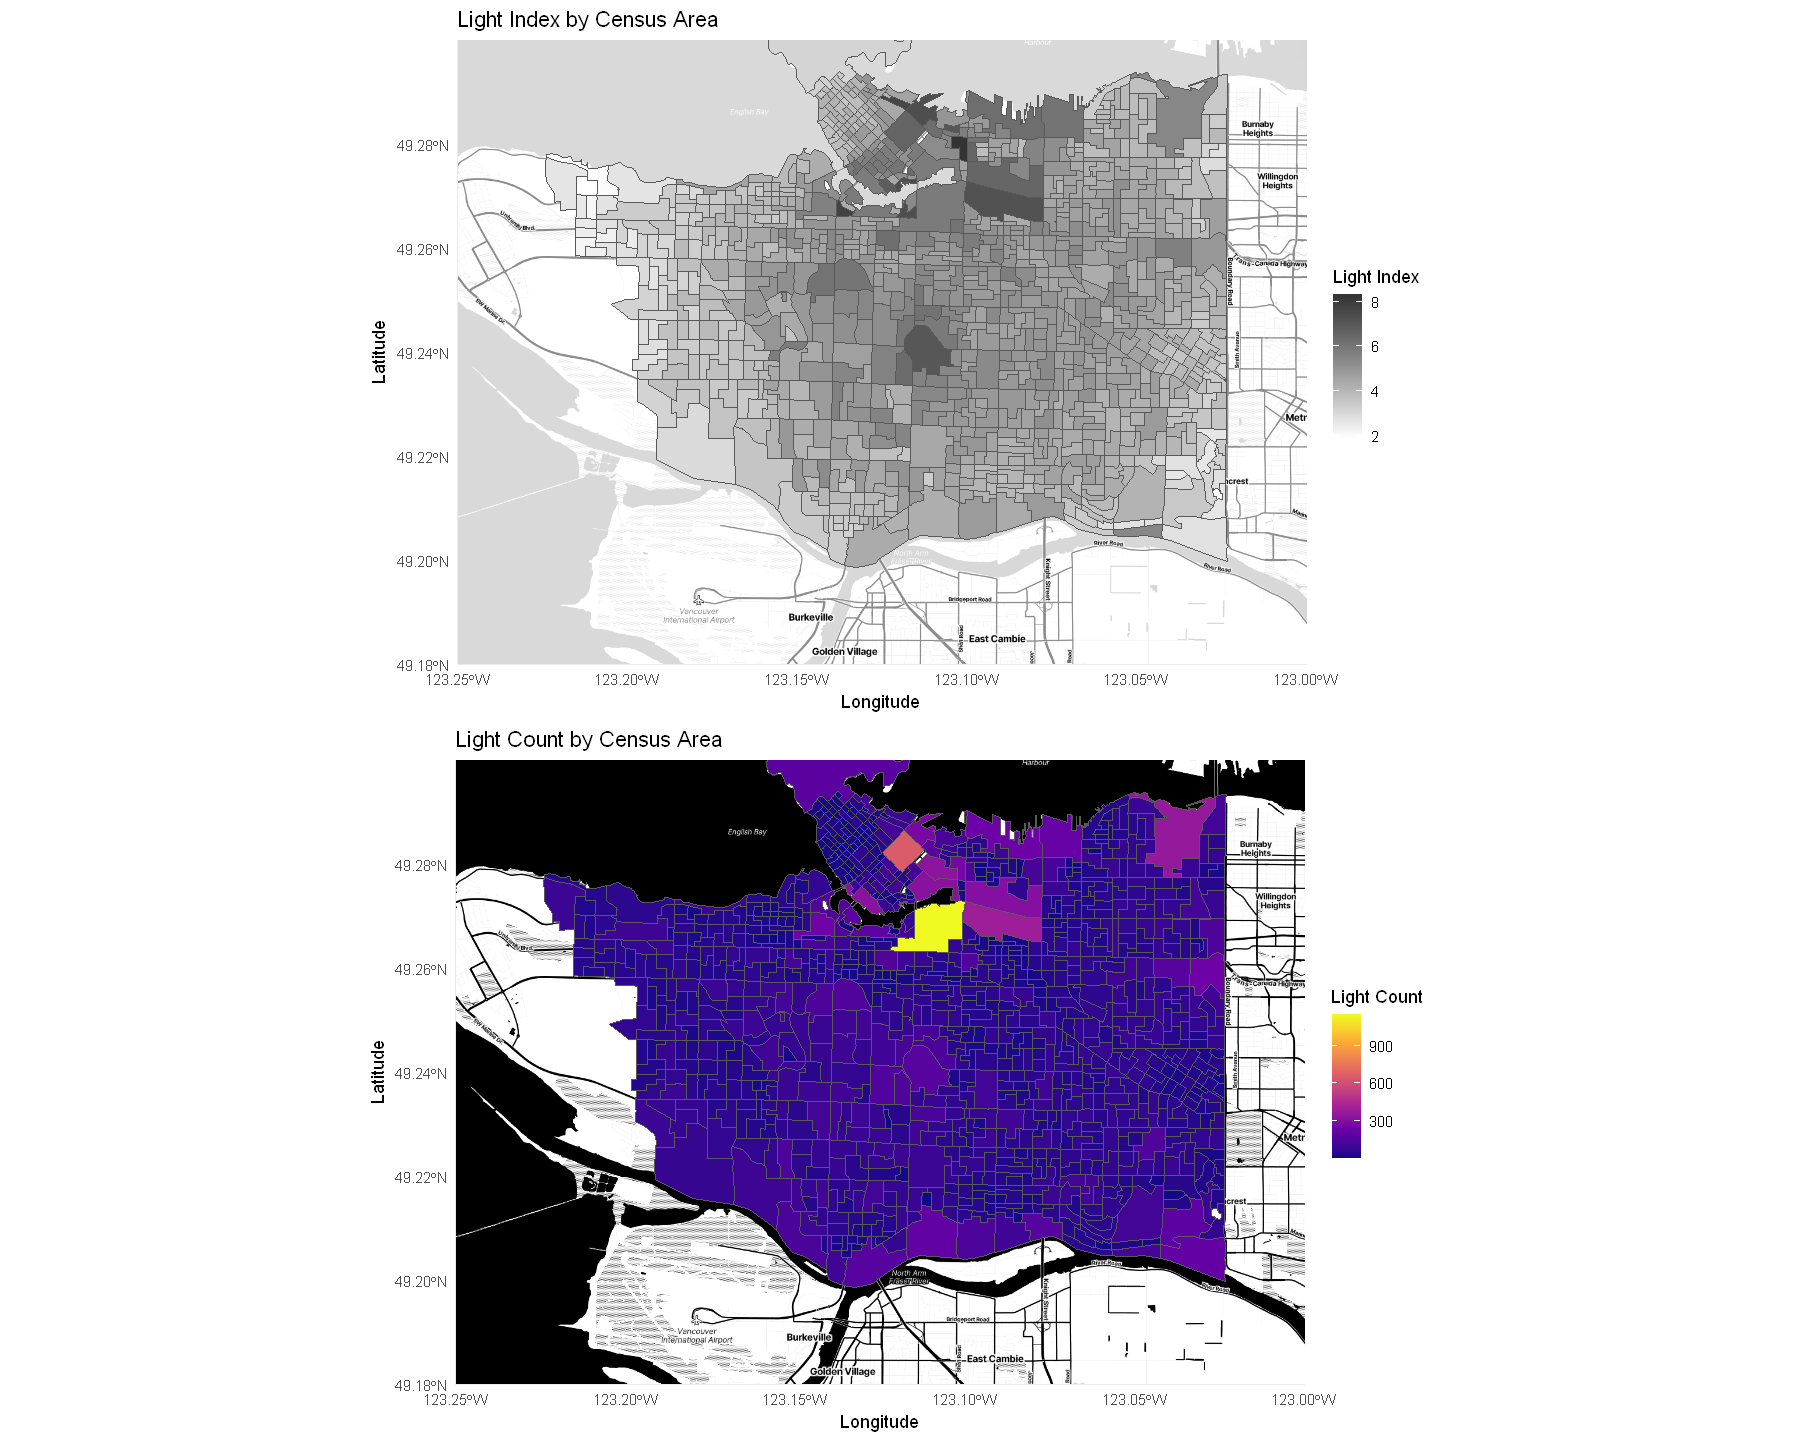

In [211]:
library(gridExtra)
grid.arrange(light_index_map, light_count_map)

From the comparison we can see that the distribution of light count is very unbalanced in Vancouver.

In [212]:
# Conduct a regression on log(light count) only
reg_log_simple2 <- lm(log_crime_rate ~  log_light_count,
              data = census_index_crime_log)

white_test <- bptest(reg_log_simple2, ~ fitted(reg_log_simple2) + I(fitted(reg_log_simple2)^2), data = census_index_crime_log)
print(white_test) 

robust_se_simple2 <- sqrt(diag(vcovHC(reg_log_simple2, type = "HC1")))

stargazer(reg_log_simple2, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se_simple2),
        single.row=TRUE)


	studentized Breusch-Pagan test

data:  reg_log_simple2
BP = 54.41, df = 2, p-value = 0.000000000001531


Log-Log Regression Results with Robust Standard Errors
                        Dependent variable:    
                    ---------------------------
                          Log Crime Rate       
-----------------------------------------------
log_light_count          0.345*** (0.048)      
Constant                 4.358*** (0.181)      
-----------------------------------------------
Observations                    989            
R2                             0.076           
Adjusted R2                    0.075           
Residual Std. Error      0.785 (df = 987)      
F Statistic           81.135*** (df = 1; 987)  
Note:               *p<0.1; **p<0.05; ***p<0.01


Adding control variables into the regression. We decided to also include variables capturing demographic factors, we decide to use mean age from census 2016 data.

In [213]:
# Load average age data
library(cancensus)
options(cancensus.api_key='CensusMapper_f228791d9506a7a747ece66db73b95be')
options(cancensus.cache_path = "/cache")

census_data_age <- get_census(dataset='CA16', regions=list(CSD="5915022"), vectors=c("v_CA16_379","v_CA16_388"), labels="detailed", geo_format="sf", level='DA')|>
    rename(mean_age = `v_CA16_379: Average age`, name = GeoUID)|>
    mutate(prop_working_age = `v_CA16_388: 15 to 64 years`/100)|>
    select(name, mean_age, prop_working_age)|>
    st_drop_geometry()|>
    glimpse()

Reading vectors data from local cache.

Reading geo data from local cache.



Rows: 993
Columns: 3
$ name             <chr> "59150307", "59150308", "59150309", "59150310", "5915…
$ mean_age         <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.6, 42.3,…
$ prop_working_age <dbl> 0.622, 0.670, 0.745, 0.815, 0.710, 0.743, 0.696, 0.73…


In [214]:
census_index_crime_log <- merge(census_index_crime_log, census_data_age, by = "name")|>
    mutate(log_mean_age = log(if_else(is.na(mean_age),0,mean_age)))|>
    glimpse()

Rows: 989
Columns: 31
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <fct> Vancouver, Vancouver, Vancouver, Vancouver, V…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

In [215]:
# Add control variables
reg_log1 <- lm(log_crime_rate ~ log_light_count+ log_mean_land_value + log_school_index + log_cultural_space_index
               + log_income + log_mean_age + immigrant_prop + education_prop, 
              data = census_index_crime_log)

white_test <- bptest(reg_log1, ~ fitted(reg_log1) + I(fitted(reg_log1)^2), data = census_index_crime_log)
print(white_test)  

robust_se1 <- sqrt(diag(vcovHC(reg_log1, type = "HC1")))

stargazer(reg_log1, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se1),
        single.row=TRUE)

vif(reg_log1)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log1
BP = 7.237, df = 2, p-value = 0.02682


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.520*** (0.037)      
log_mean_land_value            0.092** (0.036)      
log_school_index              -0.531*** (0.107)     
log_cultural_space_index      1.485*** (0.111)      
log_income                    -0.561*** (0.067)     
log_mean_age                  -0.469** (0.224)      
immigrant_prop                -0.511*** (0.153)     
education_prop                0.726*** (0.195)      
Constant                      4.226*** (0.849)      
----------------------------------------------------
Observations                         989            
R2                                  0.514           
Adjuste

Warning message in tidy.numeric(vif(reg_log1)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.163412
log_mean_land_value,1.081859
log_school_index,1.602911
log_cultural_space_index,2.450685
log_income,1.536749
log_mean_age,1.112383
immigrant_prop,1.570799
education_prop,1.717200


We decide to add a dummy control variable, "containing insite" to capture this regional characteristic

In [216]:
# Add insite dummy
insite_df <- data.frame(
  id = 1:3,
  lon = c(-123.10129, -123.10555, -123.12074), 
  lat = c(49.28160, 49.28302, 49.27544)          
) # Source: Google Map

insite_sf <- st_as_sf(insite_df, coords = c("lon", "lat"), crs = 4326)

if (st_crs(census_index_crime_log) != st_crs(insite_sf)) {
  insite_sf <- st_transform(insite_sf, st_crs(census_index_crime_log))
}

valid_geometries <- st_is_valid(census_index_crime_log)

if (!all(valid_geometries)) {
  invalid_indices <- which(!valid_geometries)
  invalid_reasons <- st_is_valid(census_index_crime_log[invalid_indices, ], reason = TRUE)
  cat("Invalid geometries found. Reasons:\n")
  print(invalid_reasons)

  census_index_crime_log_st <- st_make_valid(census_index_crime_log_st)

  valid_geometries <- st_is_valid(census_index_crime_log_st)
  
  if (!all(valid_geometries)) {
    census_index_crime_log <- st_buffer(census_index_crime_log, dist = 0)
    valid_geometries <- st_is_valid(census_index_crime_log)
    
    if (!all(valid_geometries)) {
      stop("Some geometries are still invalid after attempting to fix them.")
    }
  }
}

contains_result <- st_contains(census_index_crime_log, insite_sf, sparse = FALSE)

census_index_crime_log$insite_dummy <- as.integer(apply(contains_result, 1, any))

head(census_index_crime_log$insite_dummy)

[1] 0 0 0 0 0 0

In [217]:
# Adding insite to our model
reg_log2 <- lm(log_crime_rate ~ log_light_count+ log_mean_land_value + log_school_index + log_cultural_space_index
               + log_income + log_mean_age + immigrant_prop + education_prop + insite_dummy, 
              data = census_index_crime_log)

white_test <- bptest(reg_log2, ~ fitted(reg_log2) + I(fitted(reg_log2)^2), data = census_index_crime_log)
print(white_test)  

robust_se2 <- sqrt(diag(vcovHC(reg_log2, type = "HC1")))

stargazer(reg_log2, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        # se = list(robust_se2),
        single.row=TRUE)

vif(reg_log2)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log2
BP = 5.391, df = 2, p-value = 0.06751




Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.514*** (0.030)      
log_mean_land_value           0.095*** (0.027)      
log_school_index              -0.515*** (0.105)     
log_cultural_space_index      1.465*** (0.100)      
log_income                    -0.557*** (0.063)     
log_mean_age                  -0.494** (0.198)      
immigrant_prop                -0.496*** (0.152)     
education_prop                0.750*** (0.177)      
insite_dummy                   0.858** (0.334)      
Constant                      4.327*** (0.759)      
----------------------------------------------------
Observations                         989            
R2                                  0.517           
Adjusted R2                         0.512  

Warning message in tidy.numeric(vif(reg_log2)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.169908
log_mean_land_value,1.083138
log_school_index,1.608262
log_cultural_space_index,2.465860
log_income,1.537860
log_mean_age,1.115078
immigrant_prop,1.573438
education_prop,1.722212
insite_dummy,1.029242


Decided to include another dummy variable indicating the region is in Downtown Vancouver.

In [218]:
local_area_boundary <- get_cov_data("local-area-boundary")|>
    st_sf()

glimpse(local_area_boundary)

Reading data from temporary cache



Rows: 22
Columns: 4
$ name         <chr> "Downtown", "Hastings-Sunrise", "Kerrisdale", "Marpole", …
$ geom         <chr> "{\"coordinates\": [[[-123.11226654052733, 49.29016494657…
$ geo_point_2d <chr> "49.28074707013743, -123.11656700827415", "49.27793405209…
$ geometry     <POLYGON [°]> POLYGON ((-123.1123 49.2901..., POLYGON ((-123.05…


In [219]:
# Create a downtown dummy in our dataset
local_area_boundary_valid <- st_make_valid(local_area_boundary)

selected_areas <- local_area_boundary_valid %>%
  filter(name %in% c("West End", "Downtown", "Strathcona"))

census_index_crime_log <- st_simplify(census_index_crime_log, dTolerance = 0.01)
selected_areas <- st_simplify(selected_areas, dTolerance = 0.01)

desired_crs <- st_crs(selected_areas)
census_index_crime_log <- st_transform(census_index_crime_log, crs = desired_crs)

census_index_crime_log$is_downtown <- as.integer(
  lengths(st_intersects(census_index_crime_log, selected_areas)) > 0
)

glimpse(census_index_crime_log)

Rows: 989
Columns: 33
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <fct> Vancouver, Vancouver, Vancouver, Vancouver, V…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

In [220]:
reg_log3 <- lm(log_crime_rate ~ log_light_count+ log_mean_land_value + log_school_index + log_cultural_space_index
               + log_income + log_mean_age + immigrant_prop + education_prop + is_downtown, 
              data = census_index_crime_log)

white_test <- bptest(reg_log3, ~ fitted(reg_log3) + I(fitted(reg_log3)^2), data = census_index_crime_log)
print(white_test)  

robust_se3 <- sqrt(diag(vcovHC(reg_log3, type = "HC1")))

stargazer(reg_log3, type = "latex", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se3),
        single.row=TRUE)

vif(reg_log3)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log3
BP = 7.1907, df = 2, p-value = 0.02745


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Fri, Dec 13, 2024 - 7:15:56 PM
\begin{table}[!htbp] \centering 
  \caption{Log-Log Regression Results with Robust Standard Errors} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{1}{c}{\textit{Dependent variable:}} \\ 
\cline{2-2} 
\\[-1.8ex] & Log Crime Rate \\ 
\hline \\[-1.8ex] 
 log\_light\_count & 0.527$^{***}$ (0.037) \\ 
  log\_mean\_land\_value & 0.093$^{**}$ (0.037) \\ 
  log\_school\_index & $-$0.340$^{***}$ (0.103) \\ 
  log\_cultural\_space\_index & 1.215$^{***}$ (0.110) \\ 
  log\_income & $-$0.480$^{***}$ (0.069) \\ 
  log\_mean\_age & $-$0.534$^{**}$ (0.228) \\ 
  immigrant\_prop & $-$0.633$^{***}$ (0.151) \\ 
  education\_prop & 0.653$^{***}$ (0.193) \\ 
  is\_downtown & 0.327$^{***}$ (0.075) \\

Warning message in tidy.numeric(vif(reg_log3)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.165816
log_mean_land_value,1.081886
log_school_index,1.820793
log_cultural_space_index,3.183251
log_income,1.644139
log_mean_age,1.117257
immigrant_prop,1.611890
education_prop,1.728979
is_downtown,1.749359


We decide to move on with "Is Downtown" dummy, then we seek to add more control to improve our model. We begin by adding population density.

In [221]:
census_index_crime_log <- census_index_crime_log|>
    mutate(log_population_density = log(ifelse(population_density == 0, 0.01, population_density)))|>
    glimpse()

Rows: 989
Columns: 34
$ name                     <chr> "59150307", "59150308", "59150309", "59150310…
$ households               <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, …
$ dwellings                <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, …
$ population               <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959,…
$ population_density       <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.…
$ region                   <fct> Vancouver, Vancouver, Vancouver, Vancouver, V…
$ area_sq_km               <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, …
$ age                      <dbl> 43.2, 42.2, 41.5, 40.2, 40.1, 41.0, 43.9, 37.…
$ income                   <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, …
$ immigrant_prop           <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0…
$ education_prop           <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0…
$ school_index             <dbl> 1.967207, 2.127046, 2.283703, 3.196982, 2.388…
$ light_index     

In [222]:
reg_log4 <- lm(log_crime_rate ~ log_light_count+ log_mean_land_value + log_school_index + log_cultural_space_index
               + log_income  + log_mean_age + log_population_density + immigrant_prop + education_prop, 
              data = census_index_crime_log)

white_test <- bptest(reg_log4, ~ fitted(reg_log4) + I(fitted(reg_log4)^2), data = census_index_crime_log)
print(white_test)  

robust_se4 <- sqrt(diag(vcovHC(reg_log4, type = "HC1")))

stargazer(reg_log4, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se4),
        single.row=TRUE)

vif(reg_log4)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log4
BP = 11.777, df = 2, p-value = 0.002771


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.393*** (0.044)      
log_mean_land_value             0.020 (0.043)       
log_school_index              -0.613*** (0.108)     
log_cultural_space_index      1.651*** (0.113)      
log_income                    -0.681*** (0.077)     
log_mean_age                  -0.594*** (0.223)     
log_population_density        -0.202*** (0.051)     
immigrant_prop                -0.363** (0.157)      
education_prop                0.912*** (0.204)      
Constant                      6.747*** (1.007)      
----------------------------------------------------
Observations                         989            
R2   

Warning message in tidy.numeric(vif(reg_log4)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,2.000005
log_mean_land_value,1.384640
log_school_index,1.642140
log_cultural_space_index,2.724778
log_income,1.761072
log_mean_age,1.130023
log_population_density,3.167874
immigrant_prop,1.631791
education_prop,1.794128


In [223]:
# Omit mean land value
reg_log5 <- lm(log_crime_rate ~ log_light_count + log_school_index + log_cultural_space_index
               + log_income  + log_mean_age + log_population_density + immigrant_prop + education_prop, 
              data = census_index_crime_log)

white_test <- bptest(reg_log5, ~ fitted(reg_log5) + I(fitted(reg_log5)^2), data = census_index_crime_log)
print(white_test)  

robust_se5 <- sqrt(diag(vcovHC(reg_log5, type = "HC1")))

stargazer(reg_log5, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se5),
        single.row=TRUE)

vif(reg_log5)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log5
BP = 11.809, df = 2, p-value = 0.002727


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.388*** (0.042)      
log_school_index              -0.621*** (0.110)     
log_cultural_space_index      1.660*** (0.115)      
log_income                    -0.687*** (0.075)     
log_mean_age                  -0.583*** (0.220)     
log_population_density        -0.215*** (0.040)     
immigrant_prop                -0.355** (0.157)      
education_prop                0.936*** (0.194)      
Constant                      6.834*** (0.992)      
----------------------------------------------------
Observations                         989            
R2                                  0.526           
Adjus

Warning message in tidy.numeric(vif(reg_log5)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.918726
log_school_index,1.620445
log_cultural_space_index,2.687291
log_income,1.723980
log_mean_age,1.123207
log_population_density,2.475152
immigrant_prop,1.622450
education_prop,1.719839


In [224]:
# Add is downtown
reg_log6 <- lm(log_crime_rate ~ log_light_count + log_school_index + log_cultural_space_index
               + log_income  + log_mean_age + log_population_density + log_mean_age + immigrant_prop + education_prop + is_downtown, 
              data = census_index_crime_log)

white_test <- bptest(reg_log6, ~ fitted(reg_log6) + I(fitted(reg_log6)^2), data = census_index_crime_log)
print(white_test)  

robust_se6 <- sqrt(diag(vcovHC(reg_log6, type = "HC1")))

stargazer(reg_log6, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se6),
        single.row=TRUE)

vif(reg_log6)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log6
BP = 13.447, df = 2, p-value = 0.001202


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.345*** (0.041)      
log_school_index              -0.363*** (0.104)     
log_cultural_space_index      1.326*** (0.110)      
log_income                    -0.613*** (0.075)     
log_mean_age                  -0.758*** (0.226)     
log_population_density        -0.293*** (0.042)     
immigrant_prop                -0.475*** (0.152)     
education_prop                0.879*** (0.187)      
is_downtown                   0.486*** (0.076)      
Constant                      8.411*** (1.055)      
----------------------------------------------------
Observations                         989            
R2   

Warning message in tidy.numeric(vif(reg_log6)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.968018
log_school_index,1.816747
log_cultural_space_index,3.241528
log_income,1.767524
log_mean_age,1.140738
log_population_density,2.713300
immigrant_prop,1.642484
education_prop,1.723463
is_downtown,1.917628


Since we've decided all the controls, we want to add interaction. 

In [225]:
# Add an interaction
reg_log7 <- lm(log_crime_rate ~ log_light_count + log_school_index + log_cultural_space_index
               + log_income  + log_mean_age + log_population_density + log_mean_age + immigrant_prop + education_prop
               + is_downtown + is_downtown:log_light_count, 
              data = census_index_crime_log)

white_test <- bptest(reg_log7, ~ fitted(reg_log7) + I(fitted(reg_log7)^2), data = census_index_crime_log)
print(white_test)  

robust_se7 <- sqrt(diag(vcovHC(reg_log7, type = "HC1")))

stargazer(reg_log7, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se7),
        single.row=TRUE)

vif(reg_log7)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log7
BP = 13.19, df = 2, p-value = 0.001367


Log-Log Regression Results with Robust Standard Errors
                                Dependent variable:    
                            ---------------------------
                                  Log Crime Rate       
-------------------------------------------------------
log_light_count                  0.286*** (0.048)      
log_school_index                 -0.354*** (0.105)     
log_cultural_space_index         1.310*** (0.111)      
log_income                       -0.597*** (0.077)     
log_mean_age                     -0.735*** (0.226)     
log_population_density           -0.298*** (0.043)     
immigrant_prop                   -0.439*** (0.150)     
education_prop                   0.875*** (0.187)      
is_downtown                        0.004 (0.248)       
log_light_count:is_downtown       0.136* (0.070)       
Constant                         8.595*** (1.063)      
--------------

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log7)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,2.832492
log_school_index,1.818908
log_cultural_space_index,3.254008
log_income,1.788674
log_mean_age,1.143515
log_population_density,2.722700
immigrant_prop,1.660043
education_prop,1.723669
is_downtown,20.051078


Since the high VIF suggest it may not be a good idea to include both "is downtown" and the interaction.

In [226]:
# Add an interaction
reg_log8 <- lm(log_crime_rate ~ log_light_count + log_school_index + log_cultural_space_index
               + log_income  + log_mean_age + log_population_density + immigrant_prop + education_prop 
               + is_downtown:log_light_count, 
              data = census_index_crime_log)

white_test <- bptest(reg_log8, ~ fitted(reg_log8) + I(fitted(reg_log8)^2), data = census_index_crime_log)
print(white_test)  

robust_se8 <- sqrt(diag(vcovHC(reg_log8, type = "HC1")))

stargazer(reg_log8, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se8),
        single.row=TRUE)

vif(reg_log8)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log8
BP = 13.191, df = 2, p-value = 0.001367


Log-Log Regression Results with Robust Standard Errors
                                Dependent variable:    
                            ---------------------------
                                  Log Crime Rate       
-------------------------------------------------------
log_light_count                  0.286*** (0.043)      
log_school_index                 -0.355*** (0.106)     
log_cultural_space_index         1.310*** (0.112)      
log_income                       -0.597*** (0.076)     
log_mean_age                     -0.735*** (0.224)     
log_population_density           -0.298*** (0.043)     
immigrant_prop                   -0.438*** (0.151)     
education_prop                   0.875*** (0.187)      
log_light_count:is_downtown      0.137*** (0.021)      
Constant                         8.595*** (1.063)      
-------------------------------------------------------
Observations 

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log8)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,2.167397
log_school_index,1.810295
log_cultural_space_index,3.238634
log_income,1.783232
log_mean_age,1.135222
log_population_density,2.719252
immigrant_prop,1.631215
education_prop,1.723644
log_light_count:is_downtown,1.926411


We therefore decided our final regression model. But we still want to explore the inverse causality problem in our model and the regional fixed effect more.

### Inverse Model Check

In [227]:
# Creating an inverse causality model to shopw endogeneity
reg_log_inverse <- lm(log_light_count ~ log_crime_rate + log_school_index + log_cultural_space_index
               + log_income  + log_mean_age + log_population_density + immigrant_prop + education_prop 
               + is_downtown:log_light_count, 
              data = census_index_crime_log)

white_test <- bptest(reg_log_inverse, ~ fitted(reg_log_inverse) + I(fitted(reg_log_inverse)^2), data = census_index_crime_log)
print(white_test)  

robust_se_inverse <- sqrt(diag(vcovHC(reg_log_inverse, type = "HC1")))

stargazer(reg_log_inverse, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        se = list(robust_se_inverse),
        single.row=TRUE)

vif(reg_log_inverse)|>tidy()


	studentized Breusch-Pagan test

data:  reg_log_inverse
BP = 7.374, df = 2, p-value = 0.02505


Log-Log Regression Results with Robust Standard Errors
                                Dependent variable:    
                            ---------------------------
                                  Log Crime Rate       
-------------------------------------------------------
log_crime_rate                   0.178*** (0.026)      
log_school_index                 0.300*** (0.088)      
log_cultural_space_index          -0.080 (0.110)       
log_income                       0.171*** (0.059)      
log_mean_age                      -0.191 (0.181)       
log_population_density           -0.535*** (0.028)     
immigrant_prop                   0.609*** (0.116)      
education_prop                   -0.397*** (0.126)     
log_light_count:is_downtown      0.121*** (0.023)      
Constant                         7.883*** (0.810)      
-------------------------------------------------------
Observat

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif

Warning message in tidy.numeric(vif(reg_log_inverse)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_crime_rate,2.120199
log_school_index,1.807302
log_cultural_space_index,3.700288
log_income,1.916707
log_mean_age,1.150296
log_population_density,1.936655
immigrant_prop,1.600905
education_prop,1.754843
log_light_count:is_downtown,1.896415


### Heterogeneity Check

In [228]:
# Create a new downtown only dataset
downtown_areas <- local_area_boundary_valid %>%
  filter(name %in% c("West End", "Downtown", "Strathcona"))

selected_areas <- st_simplify(selected_areas, dTolerance = 0.01)

desired_crs <- st_crs(selected_areas)
census_index_crime_log <- st_transform(census_index_crime_log, crs = desired_crs)

census_index_crime_log_dt <- st_join(
  census_index_crime_log,
  downtown_areas,
  join = st_within,
  left = FALSE
)

glimpse(census_index_crime_log_dt)

Rows: 112
Columns: 37
$ name.x                   <chr> "59150751", "59150752", "59150753", "59150754…
$ households               <int> 349, 120, 116, 240, 413, 76, 254, 287, 191, 6…
$ dwellings                <int> 379, 142, 130, 267, 454, 109, 261, 299, 228, …
$ population               <dbl> 782, 300, 271, 456, 779, 203, 499, 577, 644, …
$ population_density       <dbl> 895.7, 7537.7, 9609.9, 10654.2, 15096.9, 8388…
$ region                   <fct> Vancouver, Vancouver, Vancouver, Vancouver, V…
$ area_sq_km               <dbl> 0.87307, 0.03983, 0.02826, 0.04282, 0.05163, …
$ age                      <dbl> 47.1, 38.9, 38.4, 42.0, 44.7, 41.5, 54.0, 60.…
$ income                   <dbl> 0.34624, 0.73216, 0.62080, 0.41600, 0.17740, …
$ immigrant_prop           <dbl> 0.33248082, 0.40000000, 0.16605166, 0.2850877…
$ education_prop           <dbl> 0.23657289, 0.38333333, 0.38745387, 0.2960526…
$ school_index             <dbl> 3.600271, 3.508716, 3.474039, 3.433914, 3.441…
$ light_index     

In [229]:
# Carry out a downtown only regression
reg_log_dt <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income  + log_mean_age + log_population_density + immigrant_prop + education_prop,
              data = census_index_crime_log_dt)

white_test <- bptest(reg_log_dt, ~ fitted(reg_log_dt) + I(fitted(reg_log_dt)^2), data = census_index_crime_log_dt)
print(white_test) 

robust_se_dt <- sqrt(diag(vcovHC(reg_log_dt, type = "HC1")))

stargazer(reg_log_dt, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        # se = list(robust_se_dt),
        single.row=TRUE)
vif(reg_log_dt)|>
    tidy()


	studentized Breusch-Pagan test

data:  reg_log_dt
BP = 0.98093, df = 2, p-value = 0.6123


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.467*** (0.098)      
log_school_index              -1.664** (0.709)      
log_cultural_space_index      1.745*** (0.591)      
log_income                     -0.250 (0.244)       
log_mean_age                  -1.177** (0.554)      
log_population_density        -0.457*** (0.119)     
immigrant_prop                 -0.408 (0.615)       
education_prop                 -0.703 (0.870)       
Constant                      13.482*** (2.952)     
----------------------------------------------------
Observations                         112            
R2                                  0.553           
Adju

Warning message in tidy.numeric(vif(reg_log_dt)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.790053
log_school_index,1.634793
log_cultural_space_index,1.674331
log_income,3.075197
log_mean_age,1.487660
log_population_density,1.813331
immigrant_prop,1.247169
education_prop,3.692439


Since we noticed the homoskedasticity of this model, we decide to explore more.

In [230]:
# Create a new dataset that exclude downtown
non_downtown_areas <- local_area_boundary_valid %>%
  filter(!name %in% c("West End", "Downtown", "Strathcona"))

census_index_crime_log_ut <- st_join(
  census_index_crime_log,
  non_downtown_areas,
  join = st_within,
  left = FALSE
)

glimpse(census_index_crime_log_ut)

Rows: 608
Columns: 37
$ name.x                   <chr> "59150309", "59150311", "59150329", "59150330…
$ households               <int> 269, 181, 333, 174, 275, 246, 185, 192, 213, …
$ dwellings                <int> 299, 199, 356, 189, 307, 264, 202, 208, 225, …
$ population               <dbl> 745, 532, 959, 506, 782, 683, 541, 507, 618, …
$ population_density       <dbl> 6663.7, 6567.9, 3109.6, 6462.3, 5068.0, 6103.…
$ region                   <fct> Vancouver, Vancouver, Vancouver, Vancouver, V…
$ area_sq_km               <dbl> 0.11190, 0.08094, 0.30854, 0.07820, 0.15441, …
$ age                      <dbl> 41.5, 40.1, 42.3, 42.1, 42.0, 43.6, 44.8, 45.…
$ income                   <dbl> 0.84736, 0.82517, 0.66688, 0.82176, 0.67840, …
$ immigrant_prop           <dbl> 0.3557047, 0.4041353, 0.5422315, 0.3557312, 0…
$ education_prop           <dbl> 0.3154362, 0.2537594, 0.1876955, 0.1581028, 0…
$ school_index             <dbl> 2.283703, 2.388786, 2.677803, 2.721358, 3.545…
$ light_index     

In [231]:
reg_log_ut <- lm(log_crime_rate ~  log_light_count + log_school_index +  log_cultural_space_index
               + log_income + log_mean_age + log_population_density + immigrant_prop + education_prop,
              data = census_index_crime_log_ut)

white_test <- bptest(reg_log_ut, ~ fitted(reg_log_ut) + I(fitted(reg_log_ut)^2), data = census_index_crime_log_ut)
print(white_test) 

robust_se_ut <- sqrt(diag(vcovHC(reg_log_ut, type = "HC1")))

stargazer(reg_log_ut, type = "text", 
        title = "Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log Crime Rate"), 
        # se = list(robust_se_ut),
        single.row=TRUE)

vif(reg_log_ut)|>
        tidy()


	studentized Breusch-Pagan test

data:  reg_log_ut
BP = 4.7558, df = 2, p-value = 0.09275


Log-Log Regression Results with Robust Standard Errors
                             Dependent variable:    
                         ---------------------------
                               Log Crime Rate       
----------------------------------------------------
log_light_count               0.294*** (0.052)      
log_school_index               -0.219* (0.122)      
log_cultural_space_index      1.208*** (0.126)      
log_income                    -0.612*** (0.088)     
log_mean_age                  -1.060*** (0.251)     
log_population_density        -0.237*** (0.053)     
immigrant_prop                -0.528*** (0.179)     
education_prop                1.114*** (0.197)      
Constant                      9.138*** (1.166)      
----------------------------------------------------
Observations                         608            
R2                                  0.459           
Adju

Warning message in tidy.numeric(vif(reg_log_ut)):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
log_light_count,1.989573
log_school_index,1.929550
log_cultural_space_index,2.746155
log_income,1.693297
log_mean_age,1.092807
log_population_density,2.532660
immigrant_prop,1.936993
education_prop,1.723120


### RESET Test

In [232]:
reset_result <- resettest(reg_log8, power = 3, type = "fitted")
print(reset_result)


	RESET test

data:  reg_log8
RESET = 4.6731, df1 = 1, df2 = 978, p-value = 0.03088



The p-value of RESET test that's lower than 0.05 suggest that we are suffering from OVB.

# Result Summary

Comparing data before and after log-log transformation.

`geom_smooth()` using formula = 'y ~ x'


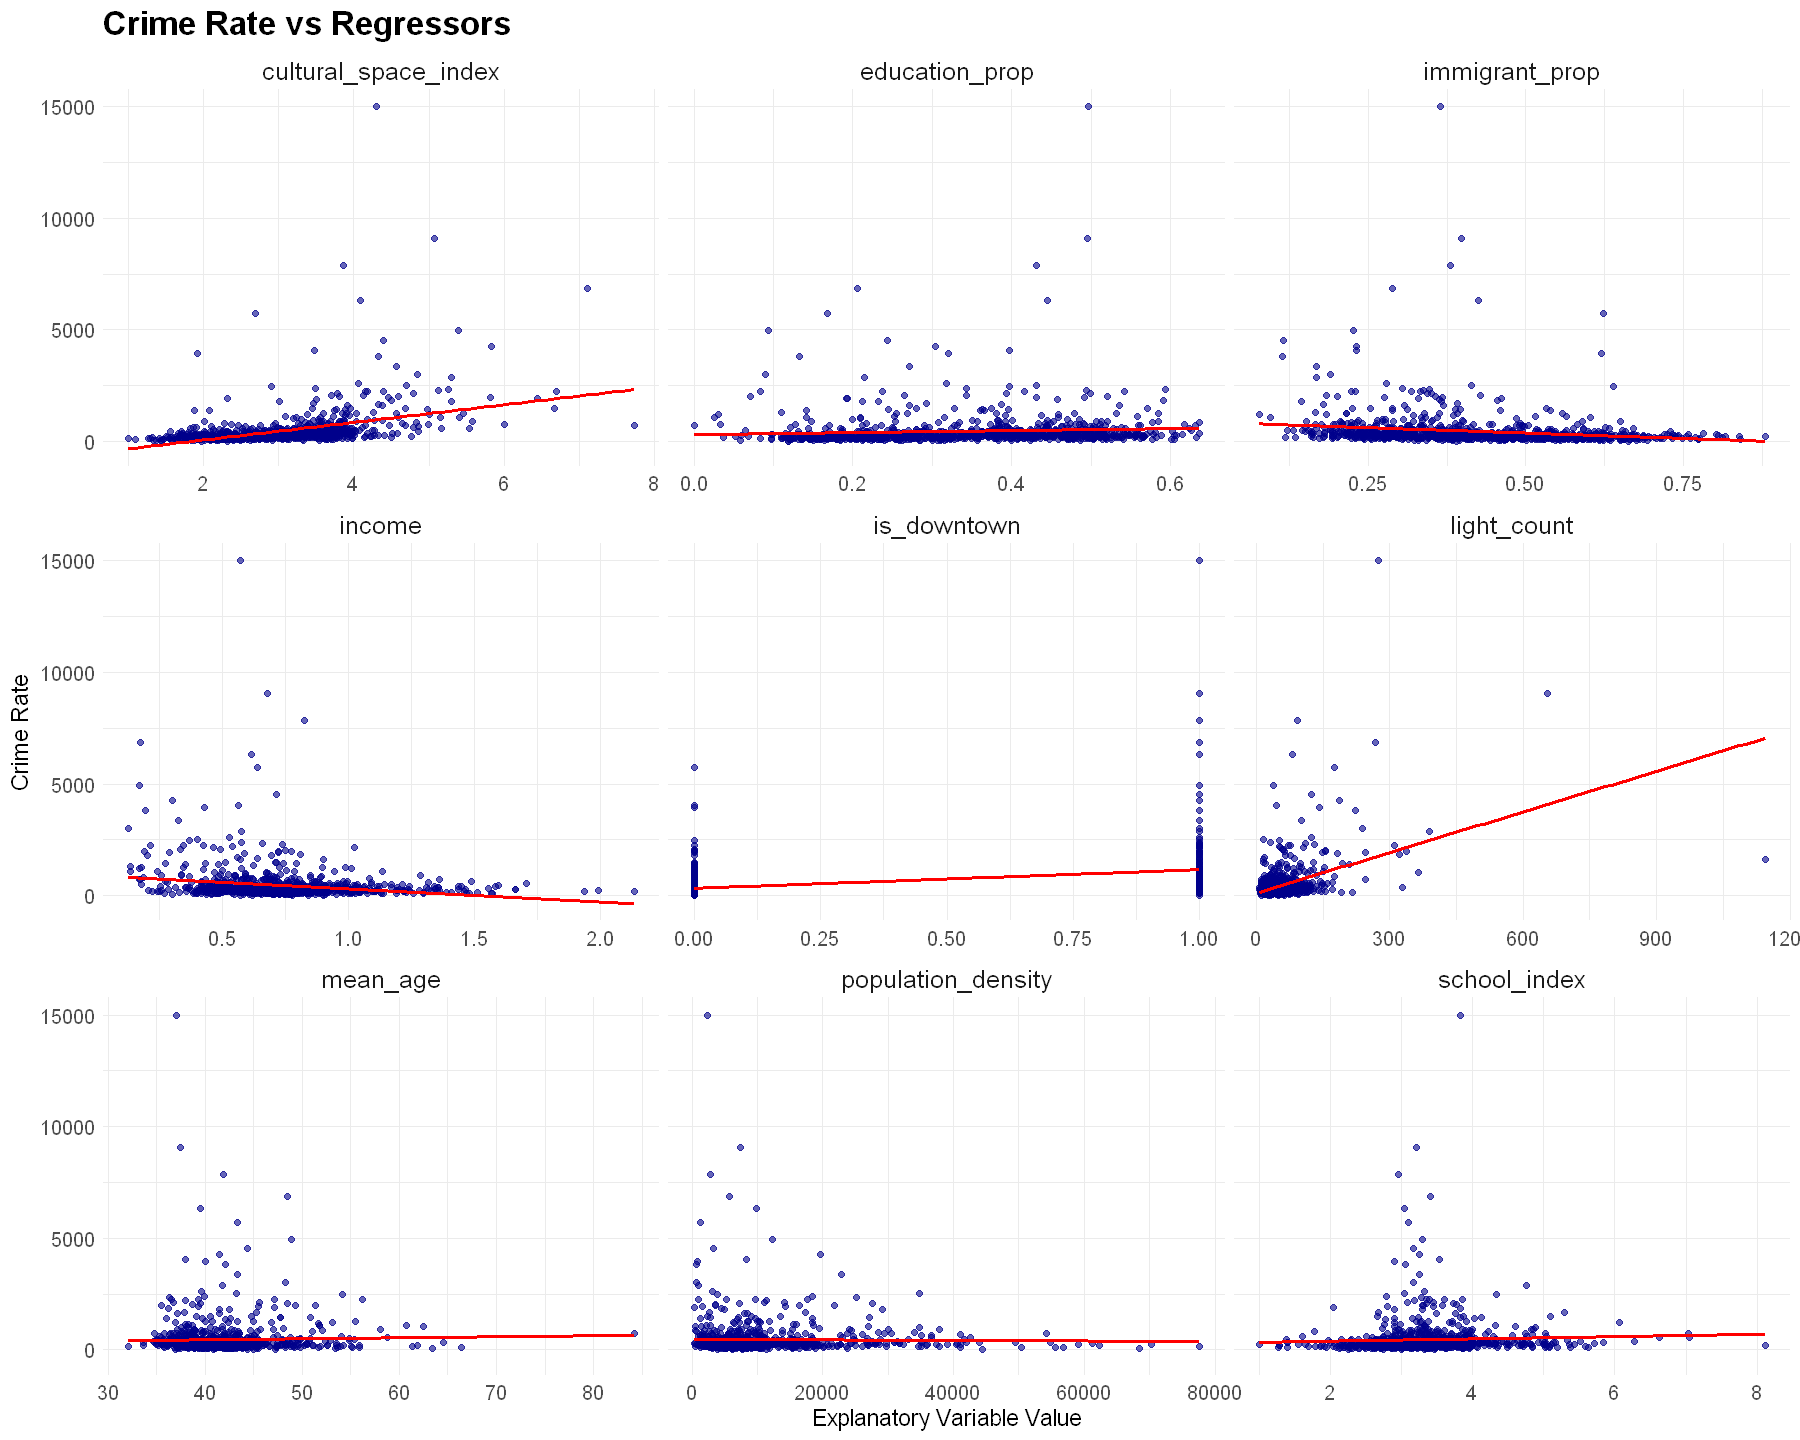

In [233]:
regressors_age_logless <- c('light_count', 'school_index', 'cultural_space_index', 
                'income', 'population_density', 'mean_age','immigrant_prop', 'education_prop','is_downtown')

long_data_age_logless <- census_index_crime_log |>
  pivot_longer(cols = regressors_age_logless,
               names_to = "regressor",
               values_to = "value")

variables_scatter_logless <- ggplot(long_data_age_logless, aes(x = value, y = crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Crime Rate vs Regressors",
       x = "Explanatory Variable Value",
       y = "Crime Rate") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

variables_scatter_logless

`geom_smooth()` using formula = 'y ~ x'


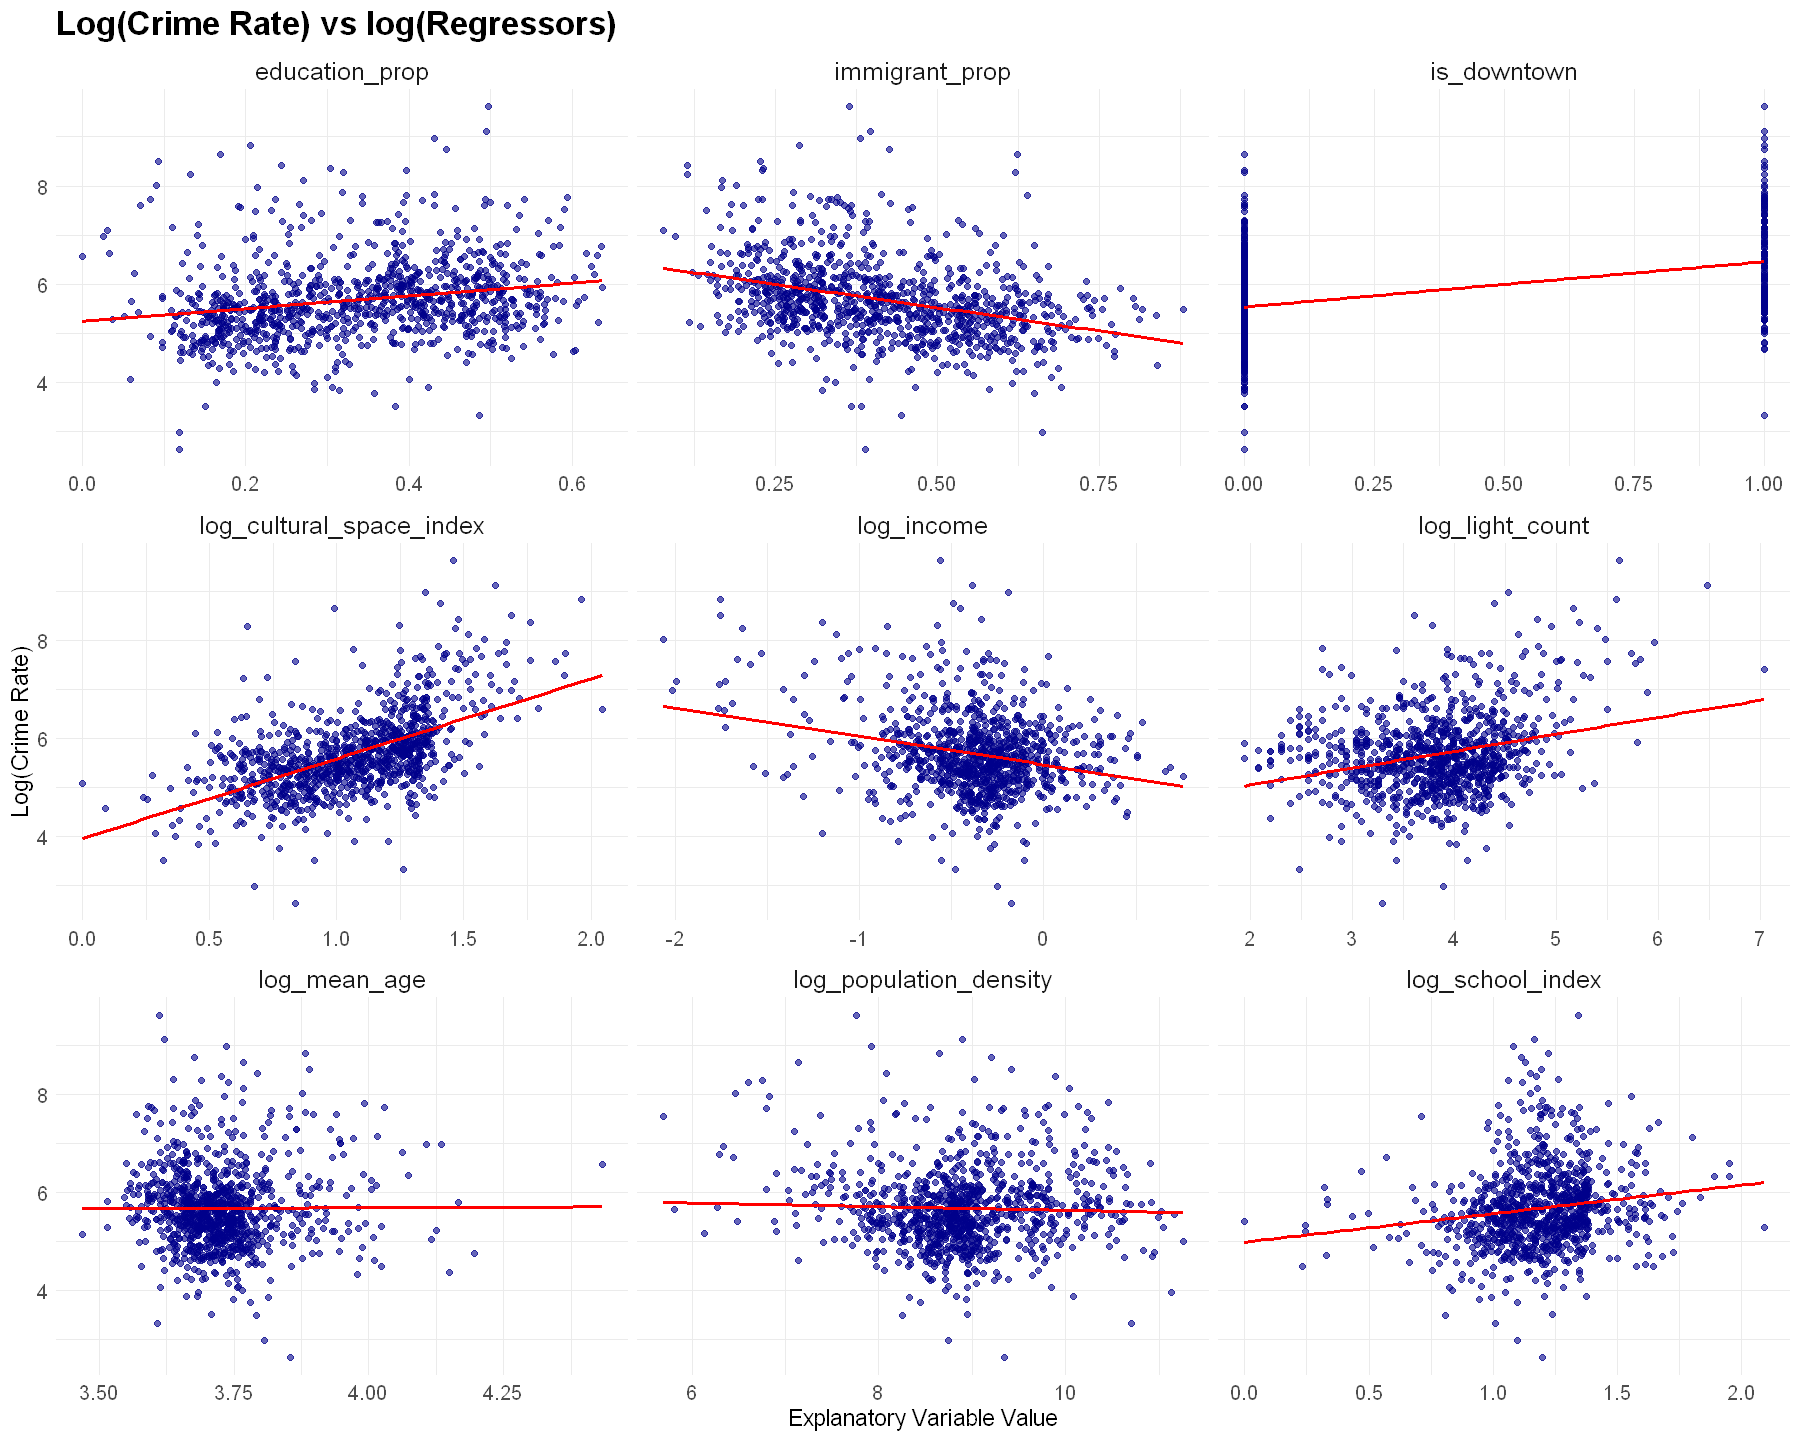

In [234]:
regressors_log <- c('log_light_count', 'log_school_index', 'log_cultural_space_index', 
                'log_income', 'log_population_density', 'log_mean_age','immigrant_prop', 'education_prop','is_downtown')

long_data_log <- census_index_crime_log |>
  pivot_longer(cols = regressors_log,
               names_to = "regressor",
               values_to = "value")

log_log_variables_scatter_log <- ggplot(long_data_log, aes(x = value, y = log_crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Log(Crime Rate) vs log(Regressors)",
       x = "Explanatory Variable Value",
       y = "Log(Crime Rate)") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

log_log_variables_scatter_log

Comparing of regression outputs.

In [235]:
# Waterfall table 1
stargazer(reg_log_simple2, reg_log1, reg_log2,  reg_log3, reg_log4, type = "text", 
        title = "Table 1: Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log (Crime Rate)"), 
          covariate.labels = c(
                "Log (Light Count)", 
               "Log (Mean Land Value)",
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income", 
               "Log (Mean Age)",
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Containing Insite",
                "Is Downtown"),
        se = list(robust_se_simple2, robust_se1, NULL, robust_se3, robust_se4),
        single.row = TRUE,
        align=TRUE)


Table 1: Log-Log Regression Results with Robust Standard Errors
                                                                               Dependent variable:                                                    
                           ---------------------------------------------------------------------------------------------------------------------------
                                                                                Log (Crime Rate)                                                      
                                     (1)                     (2)                      (3)                      (4)                      (5)           
------------------------------------------------------------------------------------------------------------------------------------------------------
Log (Light Count)             0.345*** (0.048)         0.520*** (0.037)         0.514*** (0.030)         0.527*** (0.037)         0.393*** (0.044)    
Log (Mean Land Value)        

In [236]:
# Waterfall table 2
stargazer(reg_log5, reg_log6,  reg_log7, reg_log8, type = "text", 
        title = "Table 2: Log-Log Regression Results with Robust Standard Errors", 
        dep.var.labels = c("Log (Crime Rate)"), 
          covariate.labels = c(
                "Log (Light Count)", 
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income", 
               "Log (Mean Age)",
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Is Downtown",
                "Is Downtown X Log (Light Count)"),
        se = list(robust_se5, robust_se6, robust_se7, robust_se8),
        single.row = TRUE,
        align=TRUE)


Table 2: Log-Log Regression Results with Robust Standard Errors
                                                                        Dependent variable:                                         
                                ----------------------------------------------------------------------------------------------------
                                                                          Log (Crime Rate)                                          
                                          (1)                      (2)                       (3)                      (4)           
------------------------------------------------------------------------------------------------------------------------------------
Log (Light Count)                   0.388*** (0.042)         0.345*** (0.041)         0.286*** (0.048)          0.286*** (0.043)    
Log (School Index)                 -0.621*** (0.110)        -0.363*** (0.104)         -0.354*** (0.105)        -0.355*** (0.106)    
Log 

In [237]:
# Comparison between our final model and the downtown-only and non-downtown models
stargazer(reg_log_dt, reg_log_ut, reg_log8, type = "text",
          title = "Table 3: Regression Results by Region with Robust Standard Error in Model 3",
          column.labels = c("Downtown-Only", "Non-Downtown", "Whole-Vancouver"),
          covariate.labels = c("Log (Light Count)", 
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income",
               "Log (Mean Age)",
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Is Downtown X Log (Light Count)"),
                se = list(NULL, NULL, robust_se8),
          dep.var.labels = c("Log (Crime Rate)", "Log (Crime Rate)"),
          single.row = TRUE)


Table 3: Regression Results by Region with Robust Standard Error in Model 3
                                                          Dependent variable:                           
                                ------------------------------------------------------------------------
                                                            Log (Crime Rate)                            
                                     Downtown-Only           Non-Downtown           Whole-Vancouver     
                                          (1)                     (2)                     (3)           
--------------------------------------------------------------------------------------------------------
Log (Light Count)                  0.467*** (0.098)        0.294*** (0.052)         0.286*** (0.043)    
Log (School Index)                 -1.664** (0.709)         -0.219* (0.122)        -0.355*** (0.106)    
Log (Cultural Space Index)         1.745*** (0.591)        1.208*** (0.126)        

In [238]:
# Endogeneity Comparison
stargazer(reg_log8,  reg_log_inverse, type = "text",
          title = "Table 4: Comparing the endogeneity effect",
          covariate.labels = c("Log (Light Count)",
               "Log (Crime Rate)", 
               "Log (School Index)", 
               "Log (Cultural Space Index)", 
               "Log Income",
               "Log (Mean Age)",
               "Log (Population Density)",
               "Immigrant Proportion", 
                "Education Proportion",
                "Is Downtown X Log (Light Count)"),
                se = list(robust_se8, robust_se_inverse),
          dep.var.labels = c("Log (Crime Rate)", "Log (Light Count)"),
          single.row = TRUE)


Table 4: Comparing the endogeneity effect
                                        Dependent variable:        
                                -----------------------------------
                                Log (Crime Rate)  Log (Light Count)
                                       (1)               (2)       
-------------------------------------------------------------------
Log (Light Count)               0.286*** (0.043)                   
Log (Crime Rate)                                  0.178*** (0.026) 
Log (School Index)              -0.355*** (0.106) 0.300*** (0.088) 
Log (Cultural Space Index)      1.310*** (0.112)   -0.080 (0.110)  
Log Income                      -0.597*** (0.076) 0.171*** (0.059) 
Log (Mean Age)                  -0.735*** (0.224)  -0.191 (0.181)  
Log (Population Density)        -0.298*** (0.043) -0.535*** (0.028)
Immigrant Proportion            -0.438*** (0.151) 0.609*** (0.116) 
Education Proportion            0.875*** (0.187)  -0.397*** (0.126)
Is Do